### Preprocessing, Exploration, and Analysis
Chase Kent-Dotson  
April 4, 2022

### Introduction
This workbook contains the data processing, exploration, and analysis steps of my project. First I will explore the image data and the csv information that supports the dataset, then I will explore image files from the dataset, I will then perform a crop on every image in the dataset to remove background imagery and help my models focus on vehicle imagery, and lastly I will read in, augment, and prepare my data files using data generators.     

### Table of Contents:
* [Initial Exploration of CSV Data](#2)
* [Exploration of Images and Bounding Box](#3)
* [Image Cropping](#4)
* [Data Read-In and Augmentation Methods](#5)
* [Conclusion](#6)

### Imports <a class="anchor" id="1"></a>
The required imports for this notebook are included below and their general functions are listed. 

In [1]:
# data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# image file handling
from PIL import Image
import cv2

# file directory interface
import os.path, sys

# data generation for modeling
from keras.preprocessing.image import ImageDataGenerator

### Initial Exploration of CSV Data <a class="anchor" id="2"></a>
Below I will explore the csv data that supports the image dataset. The three included files are the annotations for the training set, annotations for the test set, and class names.

In [25]:
# read in the csv files containing support information to the images

# annotations for each of the train files
df_train = pd.read_csv('data/anno_train.csv')

# annotations for each of the test files
df_test = pd.read_csv('data/anno_test.csv')

# names of each of the classes
df_names = pd.read_csv('data/names.csv')

In [88]:
# observe the annotations for the train set
df_train.head()

file   x1   y1    x2    y2  class
0  00001.jpg   39  116   569   375     14
1  00002.jpg   36  116   868   587      3
2  00003.jpg   85  109   601   381     91
3  00004.jpg  621  393  1484  1096    134
4  00005.jpg   14   36   133    99    106

In [89]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    8144 non-null   object
 1   x1      8144 non-null   int64 
 2   y1      8144 non-null   int64 
 3   x2      8144 non-null   int64 
 4   y2      8144 non-null   int64 
 5   class   8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [92]:
# observe the class balance for the train set
df_train['class'].value_counts()

119    68
79     49
161    48
167    48
144    47
       ..
175    31
64     30
158    29
99     28
136    24
Name: class, Length: 196, dtype: int64

In [28]:
# observe the annotations for the test set
df_test.head()

file   x1   y1   x2   y2  class
0  00001.jpg   30   52  246  147    181
1  00002.jpg  100   19  576  203    103
2  00003.jpg   51  105  968  659    145
3  00004.jpg   67   84  581  407    187
4  00005.jpg  140  151  593  339    185

In [29]:
# observe the class balance for the test set
df_test['class'].value_counts()

119    68
161    48
79     48
167    47
56     46
       ..
175    30
158    29
64     29
99     27
136    24
Name: class, Length: 196, dtype: int64

In [90]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    8041 non-null   object
 1   x1      8041 non-null   int64 
 2   y1      8041 non-null   int64 
 3   x2      8041 non-null   int64 
 4   y2      8041 non-null   int64 
 5   class   8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [34]:
# Identify the min and max classes for visual verification of the image files
df_names.iloc[[135,118]]

name
135  Hyundai Accent Sedan 2012
118        GMC Savana Van 2012

In [47]:
# create empty lists for class balance visualization
train_stats = []
test_stats = []

# retrieve stats for train set
train_stats.append(df_train['class'].value_counts().max())
train_stats.append(round(df_train['class'].value_counts().mean(), 1))
train_stats.append(round(df_train['class'].value_counts().median(), 1))
train_stats.append(df_train['class'].value_counts().min())

# retrieve stats for test set
test_stats.append(df_test['class'].value_counts().max())
test_stats.append(round(df_test['class'].value_counts().mean(), 1))
test_stats.append(round(df_test['class'].value_counts().median(), 1))
test_stats.append(df_test['class'].value_counts().min())

print(train_stats)
print(test_stats)

[68, 41.6, 42.0, 24]
[68, 41.0, 42.0, 24]


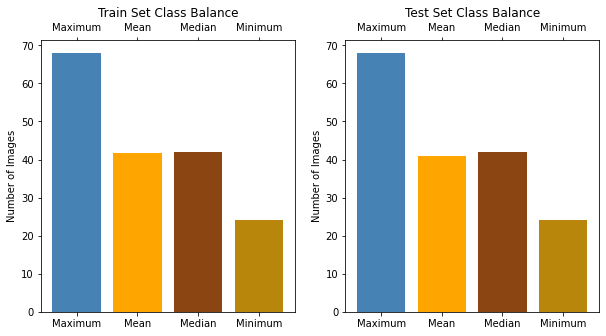

In [83]:
# set up lists for x labels and colors
stat_list = ['Maximum', 'Mean', 'Median', 'Minimum']
color_list = ['steelblue', 'orange', 'saddlebrown', 'darkgoldenrod']

# visualize class distribution data
plt.subplots(1,2, figsize=(10,5))

# train set plot
plt.subplot(1, 2, 1)
plt.bar(stat_list, train_stats, color=color_list)
plt.title('Train Set Class Balance')
plt.ylabel('Number of Images')

# train set plot
plt.subplot(1, 2, 2)
plt.bar(stat_list, test_stats, color=color_list)
plt.title('Test Set Class Balance')
plt.ylabel('Number of Images')

# save the image for use in slides
plt.savefig('report_pics/class_balance.tif', bbox_inches = "tight", dpi=300)

In [6]:
df_names.head()

name
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

### Initial Exploration of CSV Data: Findings
The train and test csv annotation files contain the image file name, the bounding box coordinates, and the class each image belongs to. The classes are each a make, model, type, and year, assigned a number 1-196 alphabetically and defined in the names csv. Neither the test nor the training data contains null values. The training data has a size of __8144__ rows, each row representing an image file, and the test data has __8041__ rows and images.  
  
Upon inspection, the __196__ classes seem relatively balanced. The maximum populated class in the training and test sets is class 119, the 2012 GMC Savanna Van, with __68__ images in each of the training and test sets. The minimum populated class in both sets is class 136, the 2012 Hyundai Accent Sedan, with __24__ images in each set. The median of both sets is __42__, while the means are very close at __41.6__ (train) and __41.0__ (test).

### Exploration of Images and Bounding Box <a class="anchor" id="3"></a>
Below I will explore reading in an image and applying the bounding box information from the corresponding csv support file previously read to a dataframe.

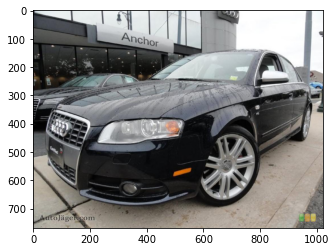

In [186]:
# view an image from the data
image = plt.imread("data/car_data/car_data/train/Audi S4 Sedan 2007/00159.jpg")
plt.imshow(image)

In [188]:
# get the metadata containing the bounding box and class

# df row = jpg# - 1
df_train.iloc[[158]]

file  x1   y1   x2   y2  class
158  00159.jpg  37  139  988  694     24

In [190]:
# find the associated class name

# df row = jpg# - 1
df_names.iloc[[23]]

name
23  Audi S4 Sedan 2007

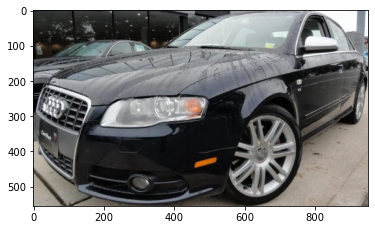

In [158]:
# test a crop of an image using the bounding box information

# read the image
image = plt.imread("data/car_data/car_data/train/Audi S4 Sedan 2007/00159.jpg")

# get the bounding box variables
ymin = df_train['y1'].values[158]
ymax = df_train['y2'].values[158]
xmin = df_train['x1'].values[158]
xmax = df_train['x2'].values[158]

# crop the image
cropped_image = image[ymin:ymax, xmin:xmax:, :]
plt.imshow(cropped_image)

In [159]:
# observe the shape of the image
image.shape

(768, 1024, 3)

### Exploration of Images and Bounding Box: Findings
Exploration of an individual image file allowed for verification of the bounding box measurements. For training models, removing the background imagery should help direct the model to learn from the features of the vehicles, rather than the backgrounds. Alternatively, this information could be used to train a different kind of model that attempts to fit bounding boxes to detect where cars are in images or video. <br><br>
The shape of the image has a third dimension, which represents RGB color. This will be important to note for image processing and the expected model input shape. 

### Image Cropping <a class="anchor" id="4"></a>
Below I will create code to apply the same bounding box crop performed above to every image within the dataset in an automated fashion. 

In [184]:
raise Exception("This code should not be run again.")
#################
# ONE TIME RUN! #
# DO NOT RERUN! #
#################

# This cell applies a crop the size and location of the bounding box dimensions
# within the dataframe to every corresponding image file

# after debugging it was run successfully on all files in the train and test sets

# set the top path and read its directories
top_path = 'C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data'
tt_dirs = os.listdir(top_path)

# set the test-train folders path and read the tt directories
for tt_dir in tt_dirs:
    tt_path = top_path + '/' + tt_dir
    class_dirs = os.listdir(tt_path)
    print(f'Working on all classes in {tt_path}...')
    
    # set the class folders path and read its directories
    for class_dir in class_dirs:
        class_path = tt_path + '/' + class_dir
        img_dirs = os.listdir(class_path)
        print(f'Working on images in {class_path}...')
        
        # set the image folders path and read directories
        for img_dir in img_dirs:
            img_path = class_path + '/' + img_dir
            new_path = img_path[0:52]  + 'test' + img_path[60:]
            print(f'Cropping image: {img_path}')
            
            # set relevant dataframe
            if tt_dir == 'train':
                df = df_train
            else:
                df = df_test
            
            # extract jpg number and convert to equivalent df row
            row_num = int(img_path[-8:][0:4]) - 1
            
            # use the bounding box values from the dataframe to crop
            ymin = df['y1'].values[row_num]
            ymax = df['y2'].values[row_num]
            xmin = df['x1'].values[row_num]
            xmax = df['x2'].values[row_num]
            
            # read in the old image
            old_img = cv2.imread(img_path, 3)
            
            # change bgr colors to rgb
            b,g,r = cv2.split(old_img)
            rgb_img = cv2.merge([r,g,b])
            
            # crop
            cropped_image = rgb_img[ymin:ymax, xmin:xmax:, :]
            
            # save the cropped image
            new_img = Image.fromarray(cropped_image)
            new_img.save(new_path)
            
            print(f'Cropped image saved: {new_path}')
    
        print(f'Finished working on images in {class_path}.')
        
    print(f'Finished working on all classes in {tt_path}.')

Working on all classes in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test...
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Type R 2001...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Type R 2001/00128.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura Integra Type R 2001/00128.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Type R 2001/00130.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura Integra Type R 2001/00130.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Type R 2001/00386.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura Integra Type R 2001/00386.jpg
Croppi

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura Integra Type R 2001/05383.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Type R 2001/05581.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura Integra Type R 2001/05581.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Type R 2001/05667.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura Integra Type R 2001/05667.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Type R 2001/05848.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura Integra Type R 2001/05848.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura Integra Ty

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura RL Sedan 2012/05260.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura RL Sedan 2012/06119.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura RL Sedan 2012/06119.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura RL Sedan 2012/06250.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura RL Sedan 2012/06250.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura RL Sedan 2012/06469.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura RL Sedan 2012/06469.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura RL Sedan 2012/06762.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Sedan 2012/04965.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Sedan 2012/05105.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Sedan 2012/05105.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Sedan 2012/05500.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Sedan 2012/05500.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Sedan 2012/05567.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Sedan 2012/05567.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Sedan 2012/05774.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Type-S 2008/04624.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Type-S 2008/04696.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Type-S 2008/04696.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Type-S 2008/04702.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Type-S 2008/04702.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Type-S 2008/04729.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TL Type-S 2008/04729.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TL Type-S 2008/04972.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TSX Sedan 2012/05122.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TSX Sedan 2012/05135.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TSX Sedan 2012/05135.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TSX Sedan 2012/05490.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TSX Sedan 2012/05490.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TSX Sedan 2012/05578.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura TSX Sedan 2012/05578.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura TSX Sedan 2012/05855.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura ZDX Hatchback 2012/05550.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura ZDX Hatchback 2012/05627.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura ZDX Hatchback 2012/05627.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura ZDX Hatchback 2012/05991.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura ZDX Hatchback 2012/05991.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura ZDX Hatchback 2012/06209.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Acura ZDX Hatchback 2012/06209.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Acura ZDX Hatchback 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/AM General Hummer SUV 2000/04768.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/AM General Hummer SUV 2000/05023.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/AM General Hummer SUV 2000/05023.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/AM General Hummer SUV 2000/05275.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/AM General Hummer SUV 2000/05275.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/AM General Hummer SUV 2000/05605.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/AM General Hummer SUV 2000/05605.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/AM Genera

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Convertible 2012/04904.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin V8 Vantage Convertible 2012/05189.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Convertible 2012/05189.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin V8 Vantage Convertible 2012/05298.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Convertible 2012/05298.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin V8 Vantage Convertible 2012/05340.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Convertible 2012/05340.jpg
Cr

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Coupe 2012/03351.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin V8 Vantage Coupe 2012/03753.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Coupe 2012/03753.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin V8 Vantage Coupe 2012/03898.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Coupe 2012/03898.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin V8 Vantage Coupe 2012/04197.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin V8 Vantage Coupe 2012/04197.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Convertible 2012/02232.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin Virage Convertible 2012/02253.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Convertible 2012/02253.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin Virage Convertible 2012/02374.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Convertible 2012/02374.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin Virage Convertible 2012/03199.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Convertible 2012/03199.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Coupe 2012/01042.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin Virage Coupe 2012/01075.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Coupe 2012/01075.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin Virage Coupe 2012/01262.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Coupe 2012/01262.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Aston Martin Virage Coupe 2012/01629.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Aston Martin Virage Coupe 2012/01629.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Sedan 1994/01012.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Sedan 1994/01335.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Sedan 1994/01335.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Sedan 1994/01617.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Sedan 1994/01617.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Sedan 1994/01893.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Sedan 1994/01893.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Sedan 1994/01917.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Wagon 1994/00321.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Wagon 1994/00514.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Wagon 1994/00514.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Wagon 1994/00826.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Wagon 1994/00826.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Wagon 1994/00868.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi 100 Wagon 1994/00868.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi 100 Wagon 1994/01083.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi A5 Coupe 2012/02099.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi A5 Coupe 2012/02107.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi A5 Coupe 2012/02107.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi A5 Coupe 2012/02138.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi A5 Coupe 2012/02138.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi A5 Coupe 2012/02185.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi A5 Coupe 2012/02185.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi A5 Coupe 2012/02345.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi R8 Coupe 2012/00929.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi R8 Coupe 2012/00957.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi R8 Coupe 2012/00957.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi R8 Coupe 2012/01105.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi R8 Coupe 2012/01105.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi R8 Coupe 2012/01694.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi R8 Coupe 2012/01694.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi R8 Coupe 2012/01884.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi R8 Coupe 2012/08029.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi R8 Coupe 2012/08034.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi R8 Coupe 2012/08034.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi R8 Coupe 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi RS 4 Convertible 2008...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi RS 4 Convertible 2008/00112.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi RS 4 Convertible 2008/00112.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi RS 4 Convertible 2008/00585.jpg
Cr

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi RS 4 Convertible 2008/08006.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi RS 4 Convertible 2008.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007/00210.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2007/00210.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007/00652.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2007/00652.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007/01114.jpg
Cropped image save

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2007/06979.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007/06994.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2007/06994.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007/07076.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2007/07076.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007/07201.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2007/07201.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2007/07651.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2012/05133.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2012/05249.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2012/05249.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2012/05538.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2012/05538.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2012/05555.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S4 Sedan 2012/05555.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S4 Sedan 2012/05842.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Convertible 2012/04974.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Convertible 2012/05148.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Convertible 2012/05148.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Convertible 2012/05494.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Convertible 2012/05494.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Convertible 2012/05554.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Convertible 2012/05554.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Convertible 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Coupe 2012/04225.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Coupe 2012/04459.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Coupe 2012/04459.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Coupe 2012/04545.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Coupe 2012/04545.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Coupe 2012/04839.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S5 Coupe 2012/04839.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S5 Coupe 2012/04893.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S6 Sedan 2011/03303.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S6 Sedan 2011/03484.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S6 Sedan 2011/03484.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S6 Sedan 2011/03634.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S6 Sedan 2011/03634.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S6 Sedan 2011/03637.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi S6 Sedan 2011/03637.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi S6 Sedan 2011/03673.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT Hatchback 2011/04236.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT Hatchback 2011/04420.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT Hatchback 2011/04420.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT Hatchback 2011/04585.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT Hatchback 2011/04585.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT Hatchback 2011/04614.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT Hatchback 2011/04614.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT Hatchback 2011/04747.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT RS Coupe 2012/03092.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT RS Coupe 2012/03231.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT RS Coupe 2012/03231.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT RS Coupe 2012/03268.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT RS Coupe 2012/03268.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT RS Coupe 2012/03493.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TT RS Coupe 2012/03493.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TT RS Coupe 2012/03568.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TTS Coupe 2012/02479.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TTS Coupe 2012/02895.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TTS Coupe 2012/02895.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TTS Coupe 2012/02973.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TTS Coupe 2012/02973.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TTS Coupe 2012/02999.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi TTS Coupe 2012/02999.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi TTS Coupe 2012/03146.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi V8 Sedan 1994/03945.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi V8 Sedan 1994/04006.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi V8 Sedan 1994/04006.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi V8 Sedan 1994/04029.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi V8 Sedan 1994/04029.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi V8 Sedan 1994/04206.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Audi V8 Sedan 1994/04206.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Audi V8 Sedan 1994/04316.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Arnage Sedan 2009/04071.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Arnage Sedan 2009/04163.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Arnage Sedan 2009/04163.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Arnage Sedan 2009/04211.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Arnage Sedan 2009/04211.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Arnage Sedan 2009/04322.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Arnage Sedan 2009/04322.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Arnage S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 2007/02262.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Flying Spur Sedan 2007/02575.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 2007/02575.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Flying Spur Sedan 2007/02644.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 2007/02644.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Flying Spur Sedan 2007/02667.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 2007/06521.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Flying Spur Sedan 2007/07274.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 2007/07274.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Flying Spur Sedan 2007/07329.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 2007/07329.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Flying Spur Sedan 2007/07439.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Flying Spur Sedan 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2007/03718.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental GT Coupe 2007/03813.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2007/03813.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental GT Coupe 2007/04500.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2007/04500.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental GT Coupe 2007/04524.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2007/04524.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2012/02243.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental GT Coupe 2012/02449.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2012/02449.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental GT Coupe 2012/02505.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2012/02505.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental GT Coupe 2012/02824.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental GT Coupe 2012/02824.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Supersports Conv. Convertible 2012/02536.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Supersports Conv. Convertible 2012/02729.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Supersports Conv. Convertible 2012/02729.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Supersports Conv. Convertible 2012/02861.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Continental Supersports Conv. Convertible 2012/02861.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Continental Supersports Conv. Convertible 2012/03116.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Mulsanne Sedan 2011/04207.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Mulsanne Sedan 2011/04230.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Mulsanne Sedan 2011/04230.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Mulsanne Sedan 2011/04394.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Mulsanne Sedan 2011/04394.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bentley Mulsanne Sedan 2011/04463.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bentley Mulsanne Sedan 2011/04463.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Be

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Convertible 2012/04771.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 1 Series Convertible 2012/04966.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Convertible 2012/04966.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 1 Series Convertible 2012/05219.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Convertible 2012/05219.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 1 Series Convertible 2012/05227.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Convertible 2012/05227.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Coupe 2012/03104.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 1 Series Coupe 2012/03354.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Coupe 2012/03354.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 1 Series Coupe 2012/03458.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Coupe 2012/03458.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 1 Series Coupe 2012/03751.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 1 Series Coupe 2012/03751.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 1 Series Coupe 2012/04096.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Sedan 2012/02246.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Sedan 2012/02250.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Sedan 2012/02250.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Sedan 2012/02261.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Sedan 2012/02261.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Sedan 2012/02395.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Sedan 2012/02395.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Sedan 2012/02959.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Wagon 2012/01430.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Wagon 2012/01543.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Wagon 2012/01543.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Wagon 2012/01669.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Wagon 2012/01669.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Wagon 2012/01761.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 3 Series Wagon 2012/01761.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 3 Series Wagon 2012/02777.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 6 Series Convertible 2007/00589.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 6 Series Convertible 2007/00692.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 6 Series Convertible 2007/00692.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 6 Series Convertible 2007/00841.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 6 Series Convertible 2007/00841.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW 6 Series Convertible 2007/00920.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW 6 Series Convertible 2007/00920.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW ActiveHybrid 5 Sedan 2012/00946.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW ActiveHybrid 5 Sedan 2012/00967.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW ActiveHybrid 5 Sedan 2012/00967.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW ActiveHybrid 5 Sedan 2012/01122.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW ActiveHybrid 5 Sedan 2012/01122.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW ActiveHybrid 5 Sedan 2012/01351.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW ActiveHybrid 5 Sedan 2012/01351.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M3 Coupe 2012/01311.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M3 Coupe 2012/01484.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M3 Coupe 2012/01484.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M3 Coupe 2012/01667.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M3 Coupe 2012/01667.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M3 Coupe 2012/02309.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M3 Coupe 2012/02309.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M3 Coupe 2012/02319.jpg
Cropped image saved: C:/Users/Chase/Document

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M5 Sedan 2010/00519.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M5 Sedan 2010/00599.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M5 Sedan 2010/00599.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M5 Sedan 2010/00818.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M5 Sedan 2010/00818.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M5 Sedan 2010/00856.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M5 Sedan 2010/00856.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M5 Sedan 2010/00866.jpg
Cropped image saved: C:/Users/Chase/Document

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M5 Sedan 2010/07977.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M5 Sedan 2010/07980.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M5 Sedan 2010/07980.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M5 Sedan 2010.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M6 Convertible 2010...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M6 Convertible 2010/00060.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M6 Convertible 2010/00060.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M6 Convertible 2010/00107.jpg
Cropped image save

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M6 Convertible 2010/05942.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M6 Convertible 2010/06146.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M6 Convertible 2010/06146.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M6 Convertible 2010/06311.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M6 Convertible 2010/06311.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M6 Convertible 2010/06530.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW M6 Convertible 2010/06530.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW M6 Convertible 2010/06655.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X3 SUV 2012/07153.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X3 SUV 2012/07239.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X3 SUV 2012/07239.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X3 SUV 2012/07343.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X3 SUV 2012/07343.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X3 SUV 2012/07719.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X3 SUV 2012/07719.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X3 SUV 2012/07794.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X5 SUV 2007/06626.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X5 SUV 2007/06696.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X5 SUV 2007/06696.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X5 SUV 2007/06884.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X5 SUV 2007/06884.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X5 SUV 2007/07052.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X5 SUV 2007/07052.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X5 SUV 2007/07240.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X6 SUV 2012/05048.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X6 SUV 2012/05476.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X6 SUV 2012/05476.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X6 SUV 2012/05651.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X6 SUV 2012/05651.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X6 SUV 2012/05661.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW X6 SUV 2012/05661.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW X6 SUV 2012/05743.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW Z4 Convertible 2012/04662.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW Z4 Convertible 2012/04701.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW Z4 Convertible 2012/04701.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW Z4 Convertible 2012/05104.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW Z4 Convertible 2012/05104.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW Z4 Convertible 2012/05140.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/BMW Z4 Convertible 2012/05140.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/BMW Z4 Convertible 2012/05239.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Convertible 2009/06011.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bugatti Veyron 16.4 Convertible 2009/06029.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Convertible 2009/06029.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bugatti Veyron 16.4 Convertible 2009/06290.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Convertible 2009/06290.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bugatti Veyron 16.4 Convertible 2009/07112.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Convertible 2009/07112.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Coupe 2009/06402.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bugatti Veyron 16.4 Coupe 2009/06501.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Coupe 2009/06501.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bugatti Veyron 16.4 Coupe 2009/06576.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Coupe 2009/06576.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Bugatti Veyron 16.4 Coupe 2009/06597.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Bugatti Veyron 16.4 Coupe 2009/06597.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Enclave SUV 2012/05086.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Enclave SUV 2012/05185.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Enclave SUV 2012/05185.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Enclave SUV 2012/05276.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Enclave SUV 2012/05276.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Enclave SUV 2012/05457.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Enclave SUV 2012/05457.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Enclave SUV 2012/05755.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Rainier SUV 2007/05641.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Rainier SUV 2007/05740.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Rainier SUV 2007/05740.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Rainier SUV 2007/05863.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Rainier SUV 2007/05863.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Rainier SUV 2007/06085.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Rainier SUV 2007/06085.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Rainier SUV 2007/06154.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Regal GS 2012/06623.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Regal GS 2012/06760.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Regal GS 2012/06760.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Regal GS 2012/06902.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Regal GS 2012/06902.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Regal GS 2012/07116.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Regal GS 2012/07116.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Regal GS 2012/07138.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Verano Sedan 2012/04888.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Verano Sedan 2012/05118.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Verano Sedan 2012/05118.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Verano Sedan 2012/05328.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Verano Sedan 2012/05328.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Verano Sedan 2012/05437.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Buick Verano Sedan 2012/05437.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Buick Verano Sedan 2012/05672.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac CTS-V Sedan 2012/03122.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac CTS-V Sedan 2012/03376.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac CTS-V Sedan 2012/03376.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac CTS-V Sedan 2012/03498.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac CTS-V Sedan 2012/03498.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac CTS-V Sedan 2012/03631.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac CTS-V Sedan 2012/03631.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac CTS-V S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac Escalade EXT Crew Cab 2007/04372.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac Escalade EXT Crew Cab 2007/04863.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac Escalade EXT Crew Cab 2007/04863.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac Escalade EXT Crew Cab 2007/04976.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac Escalade EXT Crew Cab 2007/04976.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac Escalade EXT Crew Cab 2007/04983.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac Escalade EXT Crew Cab 2007/04983.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac SRX SUV 2012/02456.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac SRX SUV 2012/02480.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac SRX SUV 2012/02480.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac SRX SUV 2012/02489.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac SRX SUV 2012/02489.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac SRX SUV 2012/02509.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Cadillac SRX SUV 2012/02509.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Cadillac SRX SUV 2012/02696.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Avalanche Crew Cab 2012/01591.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Avalanche Crew Cab 2012/01647.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Avalanche Crew Cab 2012/01647.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Avalanche Crew Cab 2012/01746.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Avalanche Crew Cab 2012/01746.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Avalanche Crew Cab 2012/01765.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Avalanche Crew Cab 2012/01765.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/00143.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Camaro Convertible 2012/00147.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/00147.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Camaro Convertible 2012/00687.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/00687.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Camaro Convertible 2012/00830.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/00830.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/06432.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Camaro Convertible 2012/06687.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/06687.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Camaro Convertible 2012/06996.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/06996.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Camaro Convertible 2012/07037.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Camaro Convertible 2012/07037.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Cobalt SS 2010/04840.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Cobalt SS 2010/04950.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Cobalt SS 2010/04950.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Cobalt SS 2010/05278.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Cobalt SS 2010/05278.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Cobalt SS 2010/06060.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Cobalt SS 2010/06060.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Cobalt SS 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette Convertible 2012/03435.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette Convertible 2012/03609.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette Convertible 2012/03609.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette Convertible 2012/03713.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette Convertible 2012/03713.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette Convertible 2012/03955.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette Convertible 2012/03955.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette Ron Fellows Edition Z06 2007/02026.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette Ron Fellows Edition Z06 2007/02188.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette Ron Fellows Edition Z06 2007/02188.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette Ron Fellows Edition Z06 2007/02239.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette Ron Fellows Edition Z06 2007/02239.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette Ron Fellows Edition Z06 2007/02501.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/01104.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette ZR1 2012/01486.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/01486.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette ZR1 2012/01620.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/01620.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette ZR1 2012/01654.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/01654.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ch

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/07395.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette ZR1 2012/07450.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/07450.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette ZR1 2012/07518.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/07518.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Corvette ZR1 2012/07683.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Corvette ZR1 2012/07683.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Express Van 2007/01427.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Express Van 2007/01434.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Express Van 2007/01434.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Express Van 2007/01678.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Express Van 2007/01678.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Express Van 2007/01993.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Express Van 2007/01993.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet HHR SS 2010/01249.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet HHR SS 2010/01621.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet HHR SS 2010/01621.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet HHR SS 2010/01901.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet HHR SS 2010/01901.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet HHR SS 2010/01920.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet HHR SS 2010/01920.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet HHR SS 2010/02451.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Impala Sedan 2007/01818.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Impala Sedan 2007/02399.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Impala Sedan 2007/02399.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Impala Sedan 2007/03036.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Impala Sedan 2007/03036.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Impala Sedan 2007/03333.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Impala Sedan 2007/03333.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ch

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Hybrid Sedan 2010/02717.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Malibu Hybrid Sedan 2010/02763.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Hybrid Sedan 2010/02763.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Malibu Hybrid Sedan 2010/02938.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Hybrid Sedan 2010/02938.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Malibu Hybrid Sedan 2010/03085.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Hybrid Sedan 2010/03085.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Sedan 2007/02508.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Malibu Sedan 2007/02519.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Sedan 2007/02519.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Malibu Sedan 2007/02568.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Sedan 2007/02568.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Malibu Sedan 2007/02847.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Malibu Sedan 2007/02847.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ch

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Monte Carlo Coupe 2007/00484.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Monte Carlo Coupe 2007/00486.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Monte Carlo Coupe 2007/00486.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Monte Carlo Coupe 2007/00494.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Monte Carlo Coupe 2007/00494.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Monte Carlo Coupe 2007/00526.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Monte Carlo Coupe 2007/00526.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/01532.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/01671.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/01671.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/01700.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/01700.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/01748.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_dat

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/06579.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/06951.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/06951.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/07005.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/07005.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Classic Extended Cab 2007/07424.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_dat

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Extended Cab 2012/03984.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Extended Cab 2012/04202.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Extended Cab 2012/04202.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Extended Cab 2012/04294.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Extended Cab 2012/04294.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Extended Cab 2012/04567.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Extended Cab 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/06552.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/06630.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/06630.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/06716.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/06716.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/07163.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 150

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Regular Cab 2012/05059.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Regular Cab 2012/05084.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Regular Cab 2012/05084.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Regular Cab 2012/05131.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Regular Cab 2012/05131.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 1500 Regular Cab 2012/05337.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 1500 Regular Cab 2012/05337

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 2500HD Regular Cab 2012/03652.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 2500HD Regular Cab 2012/03759.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 2500HD Regular Cab 2012/03759.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 2500HD Regular Cab 2012/04102.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 2500HD Regular Cab 2012/04102.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Silverado 2500HD Regular Cab 2012/04173.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Silverado 2500HD Regular 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Sonic Sedan 2012/01071.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Sonic Sedan 2012/01128.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Sonic Sedan 2012/01128.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Sonic Sedan 2012/01876.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Sonic Sedan 2012/01876.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Sonic Sedan 2012/01948.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Sonic Sedan 2012/01948.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Tahoe Hybrid SUV 2012/01354.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Tahoe Hybrid SUV 2012/01695.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Tahoe Hybrid SUV 2012/01695.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Tahoe Hybrid SUV 2012/01754.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Tahoe Hybrid SUV 2012/01754.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Tahoe Hybrid SUV 2012/01957.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Tahoe Hybrid SUV 2012/01957.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet TrailBlazer SS 2009...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet TrailBlazer SS 2009/00351.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet TrailBlazer SS 2009/00351.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet TrailBlazer SS 2009/00488.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet TrailBlazer SS 2009/00488.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet TrailBlazer SS 2009/00555.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet TrailBlazer SS 2009/00555.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_d

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet TrailBlazer SS 2009/06565.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet TrailBlazer SS 2009/06649.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet TrailBlazer SS 2009/06649.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet TrailBlazer SS 2009/06954.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet TrailBlazer SS 2009/06954.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet TrailBlazer SS 2009/07152.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet TrailBlazer SS 2009/07152.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Traverse SUV 2012/04769.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Traverse SUV 2012/04883.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Traverse SUV 2012/04883.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Traverse SUV 2012/04898.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Traverse SUV 2012/04898.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chevrolet Traverse SUV 2012/05631.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chevrolet Traverse SUV 2012/05631.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ch

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler 300 SRT-8 2010/03617.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler 300 SRT-8 2010/03871.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler 300 SRT-8 2010/03871.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler 300 SRT-8 2010/04253.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler 300 SRT-8 2010/04253.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler 300 SRT-8 2010/04447.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler 300 SRT-8 2010/04447.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler 300 SRT-8 2010/04452.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Aspen SUV 2009/00799.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Aspen SUV 2009/00908.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Aspen SUV 2009/00908.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Aspen SUV 2009/01301.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Aspen SUV 2009/01301.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Aspen SUV 2009/01305.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Aspen SUV 2009/01305.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Aspen SUV 2009/01720.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Aspen SUV 2009/07790.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Aspen SUV 2009.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Crossfire Convertible 2008...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Crossfire Convertible 2008/00520.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Crossfire Convertible 2008/00520.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Crossfire Convertible 2008/00729.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Crossfire Convertible 2008/00729.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capst

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Crossfire Convertible 2008/05503.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Crossfire Convertible 2008/05546.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Crossfire Convertible 2008/05546.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Crossfire Convertible 2008/05621.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Crossfire Convertible 2008/05621.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Crossfire Convertible 2008/05910.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Crossfire Convertible 2008/05910.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler PT Cruiser Convertible 2008/04091.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler PT Cruiser Convertible 2008/04251.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler PT Cruiser Convertible 2008/04251.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler PT Cruiser Convertible 2008/04360.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler PT Cruiser Convertible 2008/04360.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler PT Cruiser Convertible 2008/04430.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler PT Cruiser Convertible 2008/04430.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Sebring Convertible 2010/02906.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Sebring Convertible 2010/03153.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Sebring Convertible 2010/03153.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Sebring Convertible 2010/03276.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Sebring Convertible 2010/03276.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Sebring Convertible 2010/03421.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Sebring Convertible 2010/03421.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Town and Country Minivan 2012/02388.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Town and Country Minivan 2012/02674.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Town and Country Minivan 2012/02674.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Town and Country Minivan 2012/02697.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Town and Country Minivan 2012/02697.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Chrysler Town and Country Minivan 2012/02749.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Chrysler Town and Country Minivan 2012/02749.jpg
Cropping image: 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Daewoo Nubira Wagon 2002/02427.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Daewoo Nubira Wagon 2002/02594.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Daewoo Nubira Wagon 2002/02594.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Daewoo Nubira Wagon 2002/02799.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Daewoo Nubira Wagon 2002/02799.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Daewoo Nubira Wagon 2002/03040.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Daewoo Nubira Wagon 2002/03040.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Daewoo Nubira Wagon 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2007/01471.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 2007/01835.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2007/01835.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 2007/02053.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2007/02053.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 2007/02483.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2007/02483.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2012/01603.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 2012/01879.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2012/01879.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 2012/02414.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2012/02414.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 2012/02818.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caliber Wagon 2012/02818.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caliber Wagon 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/00357.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caravan Minivan 1997/00379.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/00379.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caravan Minivan 1997/00715.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/00715.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caravan Minivan 1997/00734.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/00734.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Car

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/06493.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caravan Minivan 1997/06712.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/06712.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caravan Minivan 1997/07012.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/07012.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Caravan Minivan 1997/07177.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Caravan Minivan 1997/07177.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Car

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Challenger SRT8 2011/04489.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Challenger SRT8 2011/04668.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Challenger SRT8 2011/04668.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Challenger SRT8 2011/04985.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Challenger SRT8 2011/04985.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Challenger SRT8 2011/05549.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Challenger SRT8 2011/05549.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Cha

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger Sedan 2012/03031.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger Sedan 2012/03299.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger Sedan 2012/03299.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger Sedan 2012/03566.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger Sedan 2012/03566.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger Sedan 2012/03672.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger Sedan 2012/03672.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger SRT-8 2009/02400.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger SRT-8 2009/02639.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger SRT-8 2009/02639.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger SRT-8 2009/02840.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger SRT-8 2009/02840.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger SRT-8 2009/02918.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Charger SRT-8 2009/02918.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Charger SRT-8 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Club Cab 2007/00853.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dakota Club Cab 2007/01462.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Club Cab 2007/01462.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dakota Club Cab 2007/01783.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Club Cab 2007/01783.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dakota Club Cab 2007/01900.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Club Cab 2007/01900.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dak

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Crew Cab 2010/00678.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dakota Crew Cab 2010/00951.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Crew Cab 2010/00951.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dakota Crew Cab 2010/01130.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Crew Cab 2010/01130.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dakota Crew Cab 2010/01206.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Crew Cab 2010/01206.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dak

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Dakota Crew Cab 2010/08018.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Dakota Crew Cab 2010.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007/00256.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2007/00256.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007/00569.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2007/00569.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007/0060

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2007/05576.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007/05600.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2007/05600.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007/05794.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2007/05794.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007/06116.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2007/06116.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2007/06598.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2012/05256.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2012/05384.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2012/05384.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2012/05551.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2012/05551.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2012/05693.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Durango SUV 2012/05693.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Durango SUV 2012/05832.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Journey SUV 2012/03232.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Journey SUV 2012/03329.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Journey SUV 2012/03329.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Journey SUV 2012/03392.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Journey SUV 2012/03392.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Journey SUV 2012/03437.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Journey SUV 2012/03437.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Journey SUV 2012/03572.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Magnum Wagon 2008/02114.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Magnum Wagon 2008/02189.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Magnum Wagon 2008/02189.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Magnum Wagon 2008/02384.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Magnum Wagon 2008/02384.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Magnum Wagon 2008/02478.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Magnum Wagon 2008/02478.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Magnum Wagon 2008/02481.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/00501.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/00641.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/00641.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/01101.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/01101.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/01397.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/01397.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/07032.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/07155.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/07155.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/07231.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/07231.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/07536.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/07536.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Quad Cab 2009/03982.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Quad Cab 2009/04177.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Quad Cab 2009/04177.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Quad Cab 2009/04613.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Quad Cab 2009/04613.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Ram Pickup 3500 Quad Cab 2009/04752.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Ram Pickup 3500 Quad Cab 2009/04752.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Sprinter Cargo Van 2009/02554.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Sprinter Cargo Van 2009/03145.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Sprinter Cargo Van 2009/03145.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Sprinter Cargo Van 2009/03599.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Sprinter Cargo Van 2009/03599.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Dodge Sprinter Cargo Van 2009/03806.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Dodge Sprinter Cargo Van 2009/03806.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Eagle Talon Hatchback 1998/02310.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Eagle Talon Hatchback 1998/02469.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Eagle Talon Hatchback 1998/02469.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Eagle Talon Hatchback 1998/02715.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Eagle Talon Hatchback 1998/02715.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Eagle Talon Hatchback 1998/02907.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Eagle Talon Hatchback 1998/02907.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Eagle Tal

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Eagle Talon Hatchback 1998/07799.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Eagle Talon Hatchback 1998/07932.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Eagle Talon Hatchback 1998/07932.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Eagle Talon Hatchback 1998/07939.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Eagle Talon Hatchback 1998/07939.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Eagle Talon Hatchback 1998.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari 458 Italia Convertible 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/tes

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Convertible 2012/04763.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari 458 Italia Convertible 2012/04917.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Convertible 2012/04917.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari 458 Italia Convertible 2012/04996.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Convertible 2012/04996.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari 458 Italia Convertible 2012/05052.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Convertible 2012/05052.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Coupe 2012/04594.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari 458 Italia Coupe 2012/04866.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Coupe 2012/04866.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari 458 Italia Coupe 2012/05093.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Coupe 2012/05093.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari 458 Italia Coupe 2012/05137.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari 458 Italia Coupe 2012/05137.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari California Convertible 2012/01655.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari California Convertible 2012/01817.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari California Convertible 2012/01817.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari California Convertible 2012/01833.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari California Convertible 2012/01833.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari California Convertible 2012/02323.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari California Convertible 2012/02323.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari FF Coupe 2012/01380.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari FF Coupe 2012/01419.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari FF Coupe 2012/01419.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari FF Coupe 2012/01494.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari FF Coupe 2012/01494.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari FF Coupe 2012/01890.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari FF Coupe 2012/01890.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari FF Coupe 2012/02504.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ferrari FF Coupe 2012/08012.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ferrari FF Coupe 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Abarth 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Abarth 2012/00255.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/FIAT 500 Abarth 2012/00255.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Abarth 2012/00607.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/FIAT 500 Abarth 2012/00607.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Abarth 2012/00968.jpg
Cropped image sa

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/FIAT 500 Convertible 2012/02196.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Convertible 2012/02376.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/FIAT 500 Convertible 2012/02376.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Convertible 2012/02582.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/FIAT 500 Convertible 2012/02582.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Convertible 2012/02661.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/FIAT 500 Convertible 2012/02661.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/FIAT 500 Convert

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Fisker Karma Sedan 2012/03726.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Fisker Karma Sedan 2012/03877.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Fisker Karma Sedan 2012/03877.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Fisker Karma Sedan 2012/04216.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Fisker Karma Sedan 2012/04216.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Fisker Karma Sedan 2012/04320.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Fisker Karma Sedan 2012/04320.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Fisker Karma Sedan 2012/04678.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford E-Series Wagon Van 2012/02706.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford E-Series Wagon Van 2012/02991.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford E-Series Wagon Van 2012/02991.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford E-Series Wagon Van 2012/03065.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford E-Series Wagon Van 2012/03065.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford E-Series Wagon Van 2012/03087.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford E-Series Wagon Van 2012/03087.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Edge SUV 2012/02593.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Edge SUV 2012/02716.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Edge SUV 2012/02716.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Edge SUV 2012/02809.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Edge SUV 2012/02809.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Edge SUV 2012/02855.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Edge SUV 2012/02855.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Edge SUV 2012/02925.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Expedition EL SUV 2009/02363.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Expedition EL SUV 2009/02580.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Expedition EL SUV 2009/02580.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Expedition EL SUV 2009/02875.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Expedition EL SUV 2009/02875.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Expedition EL SUV 2009/03129.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Expedition EL SUV 2009/03129.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Fo

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2007/01140.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2007/01240.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2007/01240.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2007/01403.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2007/01403.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2007/01440.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2007/01440.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Fo

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2007/07661.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2007/07733.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2007/07733.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2007/07766.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2007/07766.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2007.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2012/05810.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2012/06137.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2012/06137.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2012/06333.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2012/06333.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-150 Regular Cab 2012/06650.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-150 Regular Cab 2012/06650.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Fo

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-450 Super Duty Crew Cab 2012/06563.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-450 Super Duty Crew Cab 2012/06691.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-450 Super Duty Crew Cab 2012/06691.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-450 Super Duty Crew Cab 2012/06934.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-450 Super Duty Crew Cab 2012/06934.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford F-450 Super Duty Crew Cab 2012/07135.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford F-450 Super Duty Crew Cab 2012/07135.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Fiesta Sedan 2012/06306.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Fiesta Sedan 2012/06313.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Fiesta Sedan 2012/06313.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Fiesta Sedan 2012/06364.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Fiesta Sedan 2012/06364.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Fiesta Sedan 2012/06437.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Fiesta Sedan 2012/06437.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Fiesta Sedan 2012/07041.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Focus Sedan 2007/06491.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Focus Sedan 2007/06511.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Focus Sedan 2007/06511.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Focus Sedan 2007/06547.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Focus Sedan 2007/06547.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Focus Sedan 2007/06584.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Focus Sedan 2007/06584.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Focus Sedan 2007/06719.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Freestar Minivan 2007/06249.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Freestar Minivan 2007/06297.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Freestar Minivan 2007/06297.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Freestar Minivan 2007/06354.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Freestar Minivan 2007/06354.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Freestar Minivan 2007/06384.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Freestar Minivan 2007/06384.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Free

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford GT Coupe 2006/02123.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford GT Coupe 2006/02207.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford GT Coupe 2006/02207.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford GT Coupe 2006/02297.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford GT Coupe 2006/02297.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford GT Coupe 2006/02523.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford GT Coupe 2006/02523.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford GT Coupe 2006/02728.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Mustang Convertible 2007/01502.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Mustang Convertible 2007/01560.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Mustang Convertible 2007/01560.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Mustang Convertible 2007/01626.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Mustang Convertible 2007/01626.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Mustang Convertible 2007/01903.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Mustang Convertible 2007/01903.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/00719.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger SuperCab 2011/00817.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/00817.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger SuperCab 2011/00858.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/00858.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger SuperCab 2011/01055.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/01055.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger Supe

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/06877.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger SuperCab 2011/07322.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/07322.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger SuperCab 2011/07460.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/07460.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger SuperCab 2011/07670.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ford Ranger SuperCab 2011/07670.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ford Ranger Supe

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Geo Metro Convertible 1993/07337.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Geo Metro Convertible 1993/07397.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Geo Metro Convertible 1993/07397.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Geo Metro Convertible 1993/07443.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Geo Metro Convertible 1993/07443.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Geo Metro Convertible 1993/07581.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Geo Metro Convertible 1993/07581.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Geo Metro

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Acadia SUV 2012/06529.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Acadia SUV 2012/06538.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Acadia SUV 2012/06538.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Acadia SUV 2012/06653.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Acadia SUV 2012/06653.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Acadia SUV 2012/07280.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Acadia SUV 2012/07280.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Acadia SUV 2012/07374.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Canyon Extended Cab 2012/05327.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Canyon Extended Cab 2012/05351.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Canyon Extended Cab 2012/05351.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Canyon Extended Cab 2012/05613.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Canyon Extended Cab 2012/05613.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Canyon Extended Cab 2012/05671.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Canyon Extended Cab 2012/05671.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Savana Van 2012/03678.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Savana Van 2012/03757.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Savana Van 2012/03757.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Savana Van 2012/03963.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Savana Van 2012/03963.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Savana Van 2012/04007.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Savana Van 2012/04007.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Savana Van 2012/04036.jpg
Cropped image saved: C:/User

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Terrain SUV 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Terrain SUV 2012/00007.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Terrain SUV 2012/00007.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Terrain SUV 2012/00062.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Terrain SUV 2012/00062.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Terrain SUV 2012/00456.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Terrain SUV 2012/00456.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Terrain SUV 2012/00481.jpg
Cropped image saved: C:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/00620.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid SUV 2012/00783.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/00783.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid SUV 2012/01315.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/01315.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid SUV 2012/01400.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/01400.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/07605.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid SUV 2012/07671.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/07671.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid SUV 2012/07698.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/07698.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid SUV 2012/07711.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/GMC Yukon Hybrid SUV 2012/07711.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/GMC Yukon Hybrid

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Coupe 2012/05184.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Coupe 2012/05216.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Coupe 2012/05216.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Coupe 2012/05688.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Coupe 2012/05688.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Coupe 2012/05760.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Coupe 2012/05760.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Coupe 2012/06263.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Sedan 2012/05973.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Sedan 2012/06363.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Sedan 2012/06363.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Sedan 2012/07006.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Sedan 2012/07006.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Sedan 2012/07188.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Accord Sedan 2012/07188.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Accord Sedan 2012/07195.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2007/04679.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Odyssey Minivan 2007/05046.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2007/05046.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Odyssey Minivan 2007/05387.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2007/05387.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Odyssey Minivan 2007/05478.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2007/05478.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Ody

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2012/03810.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Odyssey Minivan 2012/03829.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2012/03829.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Odyssey Minivan 2012/03856.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2012/03856.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Odyssey Minivan 2012/04298.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Honda Odyssey Minivan 2012/04298.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Honda Ody

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H2 SUT Crew Cab 2009/02828.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HUMMER H2 SUT Crew Cab 2009/02896.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H2 SUT Crew Cab 2009/02896.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HUMMER H2 SUT Crew Cab 2009/02946.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H2 SUT Crew Cab 2009/02946.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HUMMER H2 SUT Crew Cab 2009/02996.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H2 SUT Crew Cab 2009/02996.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HU

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H3T Crew Cab 2010/02132.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HUMMER H3T Crew Cab 2010/02515.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H3T Crew Cab 2010/02515.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HUMMER H3T Crew Cab 2010/03005.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H3T Crew Cab 2010/03005.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HUMMER H3T Crew Cab 2010/03302.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/HUMMER H3T Crew Cab 2010/03302.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/HUMMER H3T Crew Cab 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Accent Sedan 2012/02000.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Accent Sedan 2012/02429.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Accent Sedan 2012/02429.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Accent Sedan 2012/02900.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Accent Sedan 2012/02900.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Accent Sedan 2012/02965.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Accent Sedan 2012/02965.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Accent S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Azera Sedan 2012/03571.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Azera Sedan 2012/03669.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Azera Sedan 2012/03669.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Azera Sedan 2012/03926.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Azera Sedan 2012/03926.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Azera Sedan 2012/04132.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Azera Sedan 2012/04132.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Azera Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Sedan 2007/03882.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Elantra Sedan 2007/03981.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Sedan 2007/03981.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Elantra Sedan 2007/04107.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Sedan 2007/04107.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Elantra Sedan 2007/04215.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Sedan 2007/04215.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai E

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Touring Hatchback 2012/02679.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Elantra Touring Hatchback 2012/02836.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Touring Hatchback 2012/02836.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Elantra Touring Hatchback 2012/03118.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Touring Hatchback 2012/03118.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Elantra Touring Hatchback 2012/03577.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Elantra Touring Hatchback 2012/03577.jpg
Cropping image: 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Genesis Sedan 2012/01314.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Genesis Sedan 2012/01322.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Genesis Sedan 2012/01322.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Genesis Sedan 2012/01376.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Genesis Sedan 2012/01376.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Genesis Sedan 2012/01514.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Genesis Sedan 2012/01514.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai G

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Genesis Sedan 2012/07978.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Genesis Sedan 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Santa Fe SUV 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Santa Fe SUV 2012/00539.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Santa Fe SUV 2012/00539.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Santa Fe SUV 2012/00761.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Santa Fe SUV 2012/00761.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sant

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Hybrid Sedan 2012/00821.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sonata Hybrid Sedan 2012/00876.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Hybrid Sedan 2012/00876.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sonata Hybrid Sedan 2012/00892.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Hybrid Sedan 2012/00892.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sonata Hybrid Sedan 2012/00904.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Hybrid Sedan 2012/00904.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Sedan 2012/01651.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sonata Sedan 2012/01697.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Sedan 2012/01697.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sonata Sedan 2012/01984.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Sedan 2012/01984.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sonata Sedan 2012/02203.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Sonata Sedan 2012/02203.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Sonata S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Tucson SUV 2012/00752.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Tucson SUV 2012/00776.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Tucson SUV 2012/00776.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Tucson SUV 2012/00846.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Tucson SUV 2012/00846.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Tucson SUV 2012/00934.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Tucson SUV 2012/00934.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Tucson SUV 2012/01340.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Tucson SUV 2012/08021.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Tucson SUV 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veloster Hatchback 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veloster Hatchback 2012/00058.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veloster Hatchback 2012/00058.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veloster Hatchback 2012/00074.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veloster Hatchback 2012/00074.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SUV 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SUV 2012/00139.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veracruz SUV 2012/00139.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SUV 2012/00370.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veracruz SUV 2012/00370.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SUV 2012/00794.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veracruz SUV 2012/00794.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SU

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veracruz SUV 2012/06184.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SUV 2012/06360.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veracruz SUV 2012/06360.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SUV 2012/06578.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veracruz SUV 2012/06578.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz SUV 2012/07205.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Hyundai Veracruz SUV 2012/07205.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Hyundai Veracruz

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Infiniti G Coupe IPL 2012/05405.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Infiniti G Coupe IPL 2012/05632.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Infiniti G Coupe IPL 2012/05632.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Infiniti G Coupe IPL 2012/06173.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Infiniti G Coupe IPL 2012/06173.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Infiniti G Coupe IPL 2012/06401.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Infiniti G Coupe IPL 2012/06401.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Infiniti G Coupe

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Infiniti QX56 SUV 2011/07080.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Infiniti QX56 SUV 2011/07934.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Infiniti QX56 SUV 2011/07934.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Infiniti QX56 SUV 2011.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Isuzu Ascender SUV 2008...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Isuzu Ascender SUV 2008/00106.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Isuzu Ascender SUV 2008/00106.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Isuzu Ascender SUV 2008/00199.jp

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Isuzu Ascender SUV 2008/06904.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Isuzu Ascender SUV 2008/06918.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Isuzu Ascender SUV 2008/06918.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Isuzu Ascender SUV 2008/07206.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Isuzu Ascender SUV 2008/07206.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Isuzu Ascender SUV 2008/07229.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Isuzu Ascender SUV 2008/07229.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Isuzu Ascender SUV 2008/07234.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jaguar XK XKR 2012/05908.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jaguar XK XKR 2012/05916.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jaguar XK XKR 2012/05916.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jaguar XK XKR 2012/06075.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jaguar XK XKR 2012/06075.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jaguar XK XKR 2012/06366.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jaguar XK XKR 2012/06366.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jaguar XK XKR 2012/06429.jpg
Cropped image saved: C:/Users/Chase/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Compass SUV 2012/03047.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Compass SUV 2012/03203.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Compass SUV 2012/03203.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Compass SUV 2012/03452.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Compass SUV 2012/03452.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Compass SUV 2012/03513.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Compass SUV 2012/03513.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Compass SUV 2012/03581.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Grand Cherokee SUV 2012/01885.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Grand Cherokee SUV 2012/02222.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Grand Cherokee SUV 2012/02222.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Grand Cherokee SUV 2012/02248.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Grand Cherokee SUV 2012/02248.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Grand Cherokee SUV 2012/02558.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Grand Cherokee SUV 2012/02558.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/00293.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/00479.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/00479.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/00567.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/00567.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/00756.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/00756.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/00854.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/06814.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/06898.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/06898.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/07454.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/07454.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/07562.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Liberty SUV 2012/07562.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Liberty SUV 2012/07844.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Patriot SUV 2012/05818.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Patriot SUV 2012/06042.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Patriot SUV 2012/06042.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Patriot SUV 2012/06045.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Patriot SUV 2012/06045.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Patriot SUV 2012/06077.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Patriot SUV 2012/06077.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Patriot SUV 2012/06418.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Wrangler SUV 2012/03943.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Wrangler SUV 2012/04105.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Wrangler SUV 2012/04105.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Wrangler SUV 2012/04369.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Wrangler SUV 2012/04369.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Wrangler SUV 2012/04570.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Jeep Wrangler SUV 2012/04570.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Jeep Wrangler SUV 2012/04646.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Aventador Coupe 2012/02271.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Aventador Coupe 2012/02522.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Aventador Coupe 2012/02522.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Aventador Coupe 2012/02846.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Aventador Coupe 2012/02846.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Aventador Coupe 2012/02882.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Aventador Coupe 2012/02882.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/00260.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Diablo Coupe 2001/00631.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/00631.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Diablo Coupe 2001/01021.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/01021.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Diablo Coupe 2001/01469.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/01469.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/07319.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Diablo Coupe 2001/07480.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/07480.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Diablo Coupe 2001/07689.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/07689.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Diablo Coupe 2001/07870.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Diablo Coupe 2001/07870.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Gallardo LP 570-4 Superleggera 2012/05691.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Gallardo LP 570-4 Superleggera 2012/05933.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Gallardo LP 570-4 Superleggera 2012/05933.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Gallardo LP 570-4 Superleggera 2012/06040.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Gallardo LP 570-4 Superleggera 2012/06040.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Gallardo LP 570-4 Superleggera 2012/06158.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Reventon Coupe 2008/03872.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Reventon Coupe 2008/03964.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Reventon Coupe 2008/03964.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Reventon Coupe 2008/04183.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Reventon Coupe 2008/04183.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lamborghini Reventon Coupe 2008/04208.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lamborghini Reventon Coupe 2008/04208.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover LR2 SUV 2012/04137.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Land Rover LR2 SUV 2012/04884.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover LR2 SUV 2012/04884.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Land Rover LR2 SUV 2012/05038.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover LR2 SUV 2012/05038.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Land Rover LR2 SUV 2012/05130.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover LR2 SUV 2012/05130.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Land Rover LR2 SUV 2012/05152.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover Range Rover SUV 2012/02337.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Land Rover Range Rover SUV 2012/02416.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover Range Rover SUV 2012/02416.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Land Rover Range Rover SUV 2012/02710.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover Range Rover SUV 2012/02710.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Land Rover Range Rover SUV 2012/02766.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Land Rover Range Rover SUV 2012/02766.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lincoln Town Car Sedan 2011/00829.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lincoln Town Car Sedan 2011/00879.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lincoln Town Car Sedan 2011/00879.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lincoln Town Car Sedan 2011/00885.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lincoln Town Car Sedan 2011/00885.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Lincoln Town Car Sedan 2011/01334.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Lincoln Town Car Sedan 2011/01334.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Li

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Maybach Landaulet Convertible 2012/02110.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Maybach Landaulet Convertible 2012/03219.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Maybach Landaulet Convertible 2012/03219.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Maybach Landaulet Convertible 2012/03611.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Maybach Landaulet Convertible 2012/03611.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Maybach Landaulet Convertible 2012/03782.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Maybach Landaulet Convertible 2012/03782.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mazda Tribute SUV 2011/00667.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mazda Tribute SUV 2011/00762.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mazda Tribute SUV 2011/00762.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mazda Tribute SUV 2011/00888.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mazda Tribute SUV 2011/00888.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mazda Tribute SUV 2011/01523.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mazda Tribute SUV 2011/01523.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mazda Tribute SUV 2011/01707.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/McLaren MP4-12C Coupe 2012/00907.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/McLaren MP4-12C Coupe 2012/00972.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/McLaren MP4-12C Coupe 2012/00972.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/McLaren MP4-12C Coupe 2012/01414.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/McLaren MP4-12C Coupe 2012/01414.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/McLaren MP4-12C Coupe 2012/01596.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/McLaren MP4-12C Coupe 2012/01596.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/McLaren M

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz 300-Class Convertible 1993...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz 300-Class Convertible 1993/00188.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz 300-Class Convertible 1993/00188.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz 300-Class Convertible 1993/00263.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz 300-Class Convertible 1993/00263.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz 300-Class Convertible 1993/00376.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz 300-Class Convertible 1993/00376.jpg
Cropp

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz 300-Class Convertible 1993/06053.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz 300-Class Convertible 1993/06710.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz 300-Class Convertible 1993/06710.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz 300-Class Convertible 1993/06872.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz 300-Class Convertible 1993/06872.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz 300-Class Convertible 1993/06924.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz 300-Class Convertible 1993/06924.jpg
Cr

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz C-Class Sedan 2012/04493.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz C-Class Sedan 2012/04506.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz C-Class Sedan 2012/04506.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz C-Class Sedan 2012/04522.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz C-Class Sedan 2012/04522.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz C-Class Sedan 2012/04596.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz C-Class Sedan 2012/04596.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz E-Class Sedan 2012/01816.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz E-Class Sedan 2012/02218.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz E-Class Sedan 2012/02218.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz E-Class Sedan 2012/02314.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz E-Class Sedan 2012/02314.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz E-Class Sedan 2012/02402.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz E-Class Sedan 2012/02402.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz E-Class Sedan 2012/07875.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz E-Class Sedan 2012/07936.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz E-Class Sedan 2012/07936.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz E-Class Sedan 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz S-Class Sedan 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz S-Class Sedan 2012/00008.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz S-Class Sedan 2012/00008.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz S-Class Sedan 2012/06165.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz S-Class Sedan 2012/06194.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz S-Class Sedan 2012/06194.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz S-Class Sedan 2012/06310.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz S-Class Sedan 2012/06310.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz S-Class Sedan 2012/06543.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz S-Class Sedan 2012/06543.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz SL-Class Coupe 2009/05527.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz SL-Class Coupe 2009/06049.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz SL-Class Coupe 2009/06049.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz SL-Class Coupe 2009/06200.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz SL-Class Coupe 2009/06200.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz SL-Class Coupe 2009/06462.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz SL-Class Coupe 2009/06462.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz Sprinter Van 2012/03293.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz Sprinter Van 2012/03788.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz Sprinter Van 2012/03788.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz Sprinter Van 2012/03869.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz Sprinter Van 2012/03869.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mercedes-Benz Sprinter Van 2012/03949.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mercedes-Benz Sprinter Van 2012/03949.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/MINI Cooper Roadster Convertible 2012/03842.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/MINI Cooper Roadster Convertible 2012/03874.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/MINI Cooper Roadster Convertible 2012/03874.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/MINI Cooper Roadster Convertible 2012/04714.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/MINI Cooper Roadster Convertible 2012/04714.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/MINI Cooper Roadster Convertible 2012/04764.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/MINI Cooper Roadster Convertible 2012/04764.jpg
Cropping image: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mitsubishi Lancer Sedan 2012/02124.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mitsubishi Lancer Sedan 2012/02125.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mitsubishi Lancer Sedan 2012/02125.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mitsubishi Lancer Sedan 2012/02241.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mitsubishi Lancer Sedan 2012/02241.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mitsubishi Lancer Sedan 2012/02448.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mitsubishi Lancer Sedan 2012/02448.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mitsubishi Lancer Sedan 2012/07834.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mitsubishi Lancer Sedan 2012/07916.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Mitsubishi Lancer Sedan 2012/07916.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Mitsubishi Lancer Sedan 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan 240SX Coupe 1998...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan 240SX Coupe 1998/00063.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan 240SX Coupe 1998/00063.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan 2

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan 240SX Coupe 1998/06380.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan 240SX Coupe 1998/06622.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan 240SX Coupe 1998/06622.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan 240SX Coupe 1998/06822.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan 240SX Coupe 1998/06822.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan 240SX Coupe 1998/06930.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan 240SX Coupe 1998/06930.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan 240SX Coupe 1998/07070.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Juke Hatchback 2012/03986.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Juke Hatchback 2012/04256.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Juke Hatchback 2012/04256.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Juke Hatchback 2012/04282.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Juke Hatchback 2012/04282.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Juke Hatchback 2012/04390.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Juke Hatchback 2012/04390.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Ju

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Leaf Hatchback 2012/03732.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Leaf Hatchback 2012/03739.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Leaf Hatchback 2012/03739.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Leaf Hatchback 2012/04005.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Leaf Hatchback 2012/04005.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Leaf Hatchback 2012/04073.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan Leaf Hatchback 2012/04073.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan Le

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan NV Passenger Van 2012/01909.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan NV Passenger Van 2012/02003.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan NV Passenger Van 2012/02003.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan NV Passenger Van 2012/02251.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan NV Passenger Van 2012/02251.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Nissan NV Passenger Van 2012/02277.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Nissan NV Passenger Van 2012/02277.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999/00156.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Plymouth Neon Coupe 1999/00156.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999/00215.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Plymouth Neon Coupe 1999/00215.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999/00261.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Plymouth Neon Coupe 1999/00261.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999/0

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Plymouth Neon Coupe 1999/06799.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999/06916.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Plymouth Neon Coupe 1999/06916.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999/07030.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Plymouth Neon Coupe 1999/07030.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 1999/07106.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Plymouth Neon Coupe 1999/07106.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Plymouth Neon Coupe 199

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Porsche Panamera Sedan 2012/05332.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Porsche Panamera Sedan 2012/05435.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Porsche Panamera Sedan 2012/05435.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Porsche Panamera Sedan 2012/05638.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Porsche Panamera Sedan 2012/05638.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Porsche Panamera Sedan 2012/05862.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Porsche Panamera Sedan 2012/05862.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Po

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ram C-V Cargo Van Minivan 2012/06828.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ram C-V Cargo Van Minivan 2012/07099.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ram C-V Cargo Van Minivan 2012/07099.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ram C-V Cargo Van Minivan 2012/07117.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ram C-V Cargo Van Minivan 2012/07117.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Ram C-V Cargo Van Minivan 2012/07190.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Ram C-V Cargo Van Minivan 2012/07190.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Ghost Sedan 2012/06920.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Ghost Sedan 2012/06950.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Ghost Sedan 2012/06950.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Ghost Sedan 2012/07191.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Ghost Sedan 2012/07191.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Ghost Sedan 2012/07479.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Ghost Sedan 2012/07479.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Phantom Drophead Coupe Convertible 2012/07246.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Phantom Drophead Coupe Convertible 2012/07431.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Phantom Drophead Coupe Convertible 2012/07431.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Phantom Drophead Coupe Convertible 2012/07510.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Phantom Drophead Coupe Convertible 2012/07510.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Phantom Drophead Coupe Convertible 2012/07718.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/c

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Phantom Sedan 2012/06515.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Phantom Sedan 2012/06559.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Phantom Sedan 2012/06559.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Phantom Sedan 2012/06612.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Phantom Sedan 2012/06612.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Rolls-Royce Phantom Sedan 2012/06837.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Rolls-Royce Phantom Sedan 2012/06837.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Scion xD Hatchback 2012/04526.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Scion xD Hatchback 2012/04964.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Scion xD Hatchback 2012/04964.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Scion xD Hatchback 2012/04979.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Scion xD Hatchback 2012/04979.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Scion xD Hatchback 2012/04981.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Scion xD Hatchback 2012/04981.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Scion xD Hatchback 2012/05008.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/smart fortwo Convertible 2012/04490.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/smart fortwo Convertible 2012/04973.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/smart fortwo Convertible 2012/04973.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/smart fortwo Convertible 2012/05236.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/smart fortwo Convertible 2012/05236.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/smart fortwo Convertible 2012/05253.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/smart fortwo Convertible 2012/05253.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Convertible 2009/03132.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8 Convertible 2009/03263.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Convertible 2009/03263.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8 Convertible 2009/03746.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Convertible 2009/03746.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8 Convertible 2009/03789.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Convertible 2009/03789.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Coupe 2009/02682.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8 Coupe 2009/02714.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Coupe 2009/02714.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8 Coupe 2009/02863.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Coupe 2009/02863.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8 Coupe 2009/03182.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Spyker C8 Coupe 2009/03182.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Spyker C8 Coupe 2009/03378.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Aerio Sedan 2007/00561.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Aerio Sedan 2007/00710.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Aerio Sedan 2007/00710.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Aerio Sedan 2007/00884.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Aerio Sedan 2007/00884.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Aerio Sedan 2007/00918.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Aerio Sedan 2007/00918.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Aerio Sedan 2007/01172.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Kizashi Sedan 2012/00736.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Kizashi Sedan 2012/00771.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Kizashi Sedan 2012/00771.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Kizashi Sedan 2012/01005.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Kizashi Sedan 2012/01005.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Kizashi Sedan 2012/01231.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Kizashi Sedan 2012/01231.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Kizashi S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki Kizashi Sedan 2012/08010.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki Kizashi Sedan 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hatchback 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hatchback 2012/00066.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Hatchback 2012/00066.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hatchback 2012/00325.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Hatchback 2012/00325.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hat

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Hatchback 2012/06058.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hatchback 2012/06790.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Hatchback 2012/06790.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hatchback 2012/07494.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Hatchback 2012/07494.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hatchback 2012/07523.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Hatchback 2012/07523.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Hatch

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Sedan 2012/03941.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Sedan 2012/04304.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Sedan 2012/04304.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Sedan 2012/04650.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Sedan 2012/04650.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Sedan 2012/05399.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Suzuki SX4 Sedan 2012/05399.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Suzuki SX4 Sedan 2012/05507.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Tesla Model S Sedan 2012/03015.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Tesla Model S Sedan 2012/03433.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Tesla Model S Sedan 2012/03433.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Tesla Model S Sedan 2012/03939.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Tesla Model S Sedan 2012/03939.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Tesla Model S Sedan 2012/03953.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Tesla Model S Sedan 2012/03953.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Tesla Model S Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota 4Runner SUV 2012/02128.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota 4Runner SUV 2012/02396.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota 4Runner SUV 2012/02396.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota 4Runner SUV 2012/02881.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota 4Runner SUV 2012/02881.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota 4Runner SUV 2012/03209.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota 4Runner SUV 2012/03209.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota 4Runner SUV 2012/03340.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Camry Sedan 2012/01551.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Camry Sedan 2012/01684.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Camry Sedan 2012/01684.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Camry Sedan 2012/01800.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Camry Sedan 2012/01800.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Camry Sedan 2012/02318.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Camry Sedan 2012/02318.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Camry Sedan 2012/02606.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Camry Sedan 2012/07987.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Camry Sedan 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla Sedan 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla Sedan 2012/00033.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Corolla Sedan 2012/00033.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla Sedan 2012/00067.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Corolla Sedan 2012/00067.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla Sed

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Corolla Sedan 2012/06629.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla Sedan 2012/06804.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Corolla Sedan 2012/06804.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla Sedan 2012/07515.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Corolla Sedan 2012/07515.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla Sedan 2012/07753.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Corolla Sedan 2012/07753.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Corolla S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Sequoia SUV 2012/06136.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Sequoia SUV 2012/06214.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Sequoia SUV 2012/06214.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Sequoia SUV 2012/06259.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Sequoia SUV 2012/06259.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Sequoia SUV 2012/06959.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Toyota Sequoia SUV 2012/06959.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Toyota Sequoia SUV 2012/07458.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Beetle Hatchback 2012/03688.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Beetle Hatchback 2012/04001.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Beetle Hatchback 2012/04001.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Beetle Hatchback 2012/04116.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Beetle Hatchback 2012/04116.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Beetle Hatchback 2012/04571.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Beetle Hatchback 2012/04571.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 1991/01422.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Golf Hatchback 1991/01677.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 1991/01677.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Golf Hatchback 1991/02335.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 1991/02335.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Golf Hatchback 1991/02966.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 1991/02966.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 2012/00766.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Golf Hatchback 2012/00977.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 2012/00977.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Golf Hatchback 2012/01141.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 2012/01141.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volkswagen Golf Hatchback 2012/01310.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volkswagen Golf Hatchback 2012/01310.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/00369.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo 240 Sedan 1993/00369.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/00402.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo 240 Sedan 1993/00402.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/00798.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo 240 Sedan 1993/00798.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/00954.jpg
Cropped image saved: C:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo 240 Sedan 1993/06537.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/06670.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo 240 Sedan 1993/06670.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/06812.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo 240 Sedan 1993/06812.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/07498.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo 240 Sedan 1993/07498.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo 240 Sedan 1993/07526.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo C30 Hatchback 2012/03677.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo C30 Hatchback 2012/03725.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo C30 Hatchback 2012/03725.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo C30 Hatchback 2012/03770.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo C30 Hatchback 2012/03770.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo C30 Hatchback 2012/04038.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo C30 Hatchback 2012/04038.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo C30 Hatchback 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo XC90 SUV 2007/04433.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo XC90 SUV 2007/04472.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo XC90 SUV 2007/04472.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo XC90 SUV 2007/04515.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo XC90 SUV 2007/04515.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo XC90 SUV 2007/04580.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/test/Volvo XC90 SUV 2007/04580.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/test/Volvo XC90 SUV 2007/04816.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura Integra Type R 2001/01012.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura Integra Type R 2001/01255.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura Integra Type R 2001/01255.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura Integra Type R 2001/01617.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura Integra Type R 2001/01617.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura Integra Type R 2001/01864.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura Integra Type R 2001/01864.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura In

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura RL Sedan 2012/00858.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura RL Sedan 2012/01031.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura RL Sedan 2012/01031.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura RL Sedan 2012/01034.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura RL Sedan 2012/01034.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura RL Sedan 2012/01535.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura RL Sedan 2012/01535.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura RL Sedan 2012/01891.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Sedan 2012/02364.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Sedan 2012/02491.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Sedan 2012/02491.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Sedan 2012/02589.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Sedan 2012/02589.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Sedan 2012/02663.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Sedan 2012/02663.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Sedan 2012/02832.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Type-S 2008/02240.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Type-S 2008/02274.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Type-S 2008/02274.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Type-S 2008/02913.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Type-S 2008/02913.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Type-S 2008/03051.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TL Type-S 2008/03051.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TL Type-S 2008/03102.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TSX Sedan 2012/02111.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TSX Sedan 2012/02457.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TSX Sedan 2012/02457.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TSX Sedan 2012/02670.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TSX Sedan 2012/02670.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TSX Sedan 2012/02739.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura TSX Sedan 2012/02739.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura TSX Sedan 2012/02843.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura ZDX Hatchback 2012/01537.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura ZDX Hatchback 2012/01706.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura ZDX Hatchback 2012/01706.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura ZDX Hatchback 2012/01901.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura ZDX Hatchback 2012/01901.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura ZDX Hatchback 2012/02359.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Acura ZDX Hatchback 2012/02359.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Acura ZDX Hatch

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/AM General Hummer SUV 2000/01277.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/AM General Hummer SUV 2000/01661.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/AM General Hummer SUV 2000/01661.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/AM General Hummer SUV 2000/01832.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/AM General Hummer SUV 2000/01832.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/AM General Hummer SUV 2000/01918.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/AM General Hummer SUV 2000/01918.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/A

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/01283.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Convertible 2012/01331.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/01331.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Convertible 2012/01413.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/01413.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Convertible 2012/01483.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/01483

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/06002.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Convertible 2012/06024.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/06024.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Convertible 2012/06206.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/06206.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Convertible 2012/06530.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Convertible 2012/06530

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Coupe 2012/04725.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Coupe 2012/04750.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Coupe 2012/04750.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Coupe 2012/05306.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Coupe 2012/05306.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin V8 Vantage Coupe 2012/05382.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin V8 Vantage Coupe 2012/05382.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Convertible 2012/06239.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin Virage Convertible 2012/06453.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Convertible 2012/06453.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin Virage Convertible 2012/06485.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Convertible 2012/06485.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin Virage Convertible 2012/06675.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Convertible 2012/06675.jpg
Cropping image: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Coupe 2012/06433.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin Virage Coupe 2012/06529.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Coupe 2012/06529.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin Virage Coupe 2012/07005.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Coupe 2012/07005.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Aston Martin Virage Coupe 2012/07048.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Aston Martin Virage Coupe 2012/07048.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Sedan 1994/06224.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Sedan 1994/06568.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Sedan 1994/06568.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Sedan 1994/06947.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Sedan 1994/06947.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Sedan 1994/07076.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Sedan 1994/07076.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Sedan 1994/07566.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Wagon 1994/05645.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Wagon 1994/05713.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Wagon 1994/05713.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Wagon 1994/05787.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Wagon 1994/05787.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Wagon 1994/05869.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi 100 Wagon 1994/05869.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi 100 Wagon 1994/06291.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi A5 Coupe 2012/02641.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi A5 Coupe 2012/02674.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi A5 Coupe 2012/02674.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi A5 Coupe 2012/02899.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi A5 Coupe 2012/02899.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi A5 Coupe 2012/03221.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi A5 Coupe 2012/03221.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi A5 Coupe 2012/03233.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi R8 Coupe 2012/01486.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi R8 Coupe 2012/01496.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi R8 Coupe 2012/01496.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi R8 Coupe 2012/01589.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi R8 Coupe 2012/01589.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi R8 Coupe 2012/01783.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi R8 Coupe 2012/01783.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi R8 Coupe 2012/01805.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi RS 4 Convertible 2008/01297.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi RS 4 Convertible 2008/01313.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi RS 4 Convertible 2008/01313.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi RS 4 Convertible 2008/01640.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi RS 4 Convertible 2008/01640.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi RS 4 Convertible 2008/01762.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi RS 4 Convertible 2008/01762.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/A

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2007/00835.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2007/01073.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2007/01073.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2007/01195.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2007/01195.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2007/01600.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2007/01600.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2007/02056.jpg
Cropped image saved: C:/User

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2012/00205.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2012/00205.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2012/00397.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2012/00397.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2012/00642.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2012/00642.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2012/00825.jpg
Cropped image saved: C:/Users/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S4 Sedan 2012/08081.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S4 Sedan 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convertible 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convertible 2012/00256.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Convertible 2012/00256.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convertible 2012/00509.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Convertible 2012/00509.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convertible 2012/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Convertible 2012/06230.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convertible 2012/06536.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Convertible 2012/06536.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convertible 2012/06545.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Convertible 2012/06545.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convertible 2012/06678.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Convertible 2012/06678.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Convert

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Coupe 2012/05674.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Coupe 2012/06105.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Coupe 2012/06105.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Coupe 2012/06193.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Coupe 2012/06193.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Coupe 2012/06509.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S5 Coupe 2012/06509.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S5 Coupe 2012/06546.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S6 Sedan 2011/03887.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S6 Sedan 2011/03952.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S6 Sedan 2011/03952.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S6 Sedan 2011/04195.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S6 Sedan 2011/04195.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S6 Sedan 2011/04237.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi S6 Sedan 2011/04237.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi S6 Sedan 2011/04581.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT Hatchback 2011/04883.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT Hatchback 2011/04944.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT Hatchback 2011/04944.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT Hatchback 2011/05067.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT Hatchback 2011/05067.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT Hatchback 2011/05359.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT Hatchback 2011/05359.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT Hatchback 2011/05392.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT RS Coupe 2012/03019.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT RS Coupe 2012/03121.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT RS Coupe 2012/03121.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT RS Coupe 2012/03349.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT RS Coupe 2012/03349.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT RS Coupe 2012/03422.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TT RS Coupe 2012/03422.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TT RS Coupe 2012/03830.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TTS Coupe 2012/01403.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TTS Coupe 2012/01880.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TTS Coupe 2012/01880.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TTS Coupe 2012/02007.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TTS Coupe 2012/02007.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TTS Coupe 2012/02474.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi TTS Coupe 2012/02474.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi TTS Coupe 2012/02598.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi V8 Sedan 1994/00239.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi V8 Sedan 1994/00261.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi V8 Sedan 1994/00261.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi V8 Sedan 1994/00603.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi V8 Sedan 1994/00603.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi V8 Sedan 1994/00653.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Audi V8 Sedan 1994/00653.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Audi V8 Sedan 1994/00975.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Arnage Sedan 2009/00398.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Arnage Sedan 2009/00513.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Arnage Sedan 2009/00513.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Arnage Sedan 2009/00910.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Arnage Sedan 2009/00910.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Arnage Sedan 2009/00987.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Arnage Sedan 2009/00987.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Sedan 2007/00749.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/00896.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Sedan 2007/00896.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/00897.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Sedan 2007/00897.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/01270.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Se

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Sedan 2007/06076.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/06369.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Sedan 2007/06369.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/06505.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Sedan 2007/06505.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Flying Spur Sedan 2007/06520.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Flying Spur Se

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2007/03436.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental GT Coupe 2007/03480.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2007/03480.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental GT Coupe 2007/03655.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2007/03655.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental GT Coupe 2007/03975.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2007/03975.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2012/03469.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental GT Coupe 2012/03560.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2012/03560.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental GT Coupe 2012/04126.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2012/04126.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental GT Coupe 2012/04328.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental GT Coupe 2012/04328.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Supersports Conv. Convertible 2012/04779.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Supersports Conv. Convertible 2012/05158.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Supersports Conv. Convertible 2012/05158.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Supersports Conv. Convertible 2012/05278.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Continental Supersports Conv. Convertible 2012/05278.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Continental Supersports Conv. Convertible 2012/05310.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStat

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Mulsanne Sedan 2011/05548.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Mulsanne Sedan 2011/05722.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Mulsanne Sedan 2011/05722.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Mulsanne Sedan 2011/05763.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Mulsanne Sedan 2011/05763.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bentley Mulsanne Sedan 2011/05803.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bentley Mulsanne Sedan 2011/05803.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Convertible 2012/03990.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 1 Series Convertible 2012/04086.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Convertible 2012/04086.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 1 Series Convertible 2012/04152.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Convertible 2012/04152.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 1 Series Convertible 2012/04548.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Convertible 2012/04548.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Coupe 2012/03634.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 1 Series Coupe 2012/03665.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Coupe 2012/03665.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 1 Series Coupe 2012/03874.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Coupe 2012/03874.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 1 Series Coupe 2012/04030.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 1 Series Coupe 2012/04030.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 1 Series Coupe 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Sedan 2012/03722.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Sedan 2012/03953.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Sedan 2012/03953.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Sedan 2012/04129.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Sedan 2012/04129.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Sedan 2012/04500.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Sedan 2012/04500.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Wagon 2012/02874.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Wagon 2012/02992.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Wagon 2012/02992.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Wagon 2012/03010.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Wagon 2012/03010.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Wagon 2012/03214.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 3 Series Wagon 2012/03214.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 3 Series Wagon 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 6 Series Convertible 2007/01353.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 6 Series Convertible 2007/01719.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 6 Series Convertible 2007/01719.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 6 Series Convertible 2007/01775.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 6 Series Convertible 2007/01775.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW 6 Series Convertible 2007/01851.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW 6 Series Convertible 2007/01851.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW ActiveHybrid 5 Sedan 2012/01059.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW ActiveHybrid 5 Sedan 2012/01512.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW ActiveHybrid 5 Sedan 2012/01512.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW ActiveHybrid 5 Sedan 2012/01714.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW ActiveHybrid 5 Sedan 2012/01714.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW ActiveHybrid 5 Sedan 2012/01839.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW ActiveHybrid 5 Sedan 2012/01839.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M3 Coupe 2012/01489.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M3 Coupe 2012/01807.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M3 Coupe 2012/01807.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M3 Coupe 2012/01993.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M3 Coupe 2012/01993.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M3 Coupe 2012/02006.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M3 Coupe 2012/02006.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M3 Coupe 2012/02033.jpg
Cropped image saved: C:/Users/Chase/

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M5 Sedan 2010...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M5 Sedan 2010/00792.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M5 Sedan 2010/00792.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M5 Sedan 2010/01582.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M5 Sedan 2010/01582.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M5 Sedan 2010/01675.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M5 Sedan 2010/01675.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M5 Sedan 2010/01825.jpg
Cropped image saved: C:/Users/Chase/Doc

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/00022.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 2010/00165.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/00165.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 2010/00623.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/00623.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 2010/00709.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/00709.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/07193.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 2010/07354.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/07354.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 2010/07672.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/07672.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 2010/07759.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW M6 Convertible 2010/07759.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW M6 Convertible 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X3 SUV 2012/07511.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X3 SUV 2012/08068.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X3 SUV 2012/08068.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X3 SUV 2012/08082.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X3 SUV 2012/08082.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X3 SUV 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X5 SUV 2007...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X5 SUV 2007/00366.jpg
Cropped image saved: C:/Users/Chase/Documents/Brai

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X5 SUV 2007/07263.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X5 SUV 2007/07308.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X5 SUV 2007/07308.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X5 SUV 2007/07311.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X5 SUV 2007/07311.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X5 SUV 2007/07389.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X5 SUV 2007/07389.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X5 SUV 2007/07592.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainS

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X6 SUV 2012/07407.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X6 SUV 2012/07417.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X6 SUV 2012/07417.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X6 SUV 2012/07651.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X6 SUV 2012/07651.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X6 SUV 2012/07678.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW X6 SUV 2012/07678.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW X6 SUV 2012/07718.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainS

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW Z4 Convertible 2012/05868.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW Z4 Convertible 2012/06051.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW Z4 Convertible 2012/06051.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW Z4 Convertible 2012/06411.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW Z4 Convertible 2012/06411.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW Z4 Convertible 2012/07027.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/BMW Z4 Convertible 2012/07027.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/BMW Z4 Convertible 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Convertible 2009/06457.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bugatti Veyron 16.4 Convertible 2009/07082.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Convertible 2009/07082.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bugatti Veyron 16.4 Convertible 2009/07108.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Convertible 2009/07108.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bugatti Veyron 16.4 Convertible 2009/07296.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Convertible 2009/07296.jpg
Cropping image: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Coupe 2009/03278.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bugatti Veyron 16.4 Coupe 2009/03330.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Coupe 2009/03330.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bugatti Veyron 16.4 Coupe 2009/03479.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Coupe 2009/03479.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Bugatti Veyron 16.4 Coupe 2009/03751.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Bugatti Veyron 16.4 Coupe 2009/03751.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Enclave SUV 2012/01201.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Enclave SUV 2012/01557.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Enclave SUV 2012/01557.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Enclave SUV 2012/01691.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Enclave SUV 2012/01691.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Enclave SUV 2012/02303.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Enclave SUV 2012/02303.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Enclave SUV 2012/02606.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Rainier SUV 2007/01945.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Rainier SUV 2007/02109.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Rainier SUV 2007/02109.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Rainier SUV 2007/02149.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Rainier SUV 2007/02149.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Rainier SUV 2007/02181.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Rainier SUV 2007/02181.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Rainier SUV 2007/02245.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Regal GS 2012/01671.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Regal GS 2012/01770.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Regal GS 2012/01770.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Regal GS 2012/01933.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Regal GS 2012/01933.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Regal GS 2012/01968.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Regal GS 2012/01968.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Regal GS 2012/02052.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Verano Sedan 2012/02906.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Verano Sedan 2012/03168.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Verano Sedan 2012/03168.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Verano Sedan 2012/03353.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Verano Sedan 2012/03353.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Verano Sedan 2012/03578.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Buick Verano Sedan 2012/03578.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Buick Verano Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac CTS-V Sedan 2012/04550.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac CTS-V Sedan 2012/04619.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac CTS-V Sedan 2012/04619.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac CTS-V Sedan 2012/05081.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac CTS-V Sedan 2012/05081.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac CTS-V Sedan 2012/05421.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac CTS-V Sedan 2012/05421.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/01289.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac Escalade EXT Crew Cab 2007/01330.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/01330.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac Escalade EXT Crew Cab 2007/01382.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/01382.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac Escalade EXT Crew Cab 2007/01447.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/01447.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/06715.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac Escalade EXT Crew Cab 2007/07426.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/07426.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac Escalade EXT Crew Cab 2007/07490.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/07490.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac Escalade EXT Crew Cab 2007/07533.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac Escalade EXT Crew Cab 2007/07533.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac SRX SUV 2012/05741.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac SRX SUV 2012/05881.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac SRX SUV 2012/05881.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac SRX SUV 2012/06345.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac SRX SUV 2012/06345.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac SRX SUV 2012/06550.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Cadillac SRX SUV 2012/06550.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Cadillac SRX SUV 2012/06972.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Avalanche Crew Cab 2012/04414.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Avalanche Crew Cab 2012/04653.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Avalanche Crew Cab 2012/04653.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Avalanche Crew Cab 2012/04657.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Avalanche Crew Cab 2012/04657.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Avalanche Crew Cab 2012/04713.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Avalanche Crew Cab 2012/04713.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Camaro Convertible 2012/01328.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Camaro Convertible 2012/01342.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Camaro Convertible 2012/01342.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Camaro Convertible 2012/01358.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Camaro Convertible 2012/01358.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Camaro Convertible 2012/01360.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Camaro Convertible 2012/01360.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/00126.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobalt SS 2010/00176.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/00176.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobalt SS 2010/00929.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/00929.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobalt SS 2010/01107.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/01107.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobal

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/07254.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobalt SS 2010/07379.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/07379.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobalt SS 2010/07437.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/07437.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobalt SS 2010/07726.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Cobalt SS 2010/07726.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Cobal

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette Convertible 2012/06902.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette Convertible 2012/06923.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette Convertible 2012/06923.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette Convertible 2012/06941.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette Convertible 2012/06941.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette Convertible 2012/07431.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette Convertible 2012/07431.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette Ron Fellows Edition Z06 2007/05555.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette Ron Fellows Edition Z06 2007/05969.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette Ron Fellows Edition Z06 2007/05969.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette Ron Fellows Edition Z06 2007/06048.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette Ron Fellows Edition Z06 2007/06048.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette Ron Fellows Edition Z06 2007/06284.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chev

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette ZR1 2012/03185.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette ZR1 2012/03291.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette ZR1 2012/03291.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette ZR1 2012/03408.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette ZR1 2012/03408.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Corvette ZR1 2012/03541.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Corvette ZR1 2012/03541.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Cargo Van 2007/02439.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Express Cargo Van 2007/02592.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Cargo Van 2007/02592.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Express Cargo Van 2007/02609.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Cargo Van 2007/02609.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Express Cargo Van 2007/02658.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Cargo Van 2007/02658.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Van 2007/01949.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Express Van 2007/02268.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Van 2007/02268.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Express Van 2007/02564.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Van 2007/02564.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Express Van 2007/02672.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Express Van 2007/02672.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet HHR SS 2010/03060.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet HHR SS 2010/03236.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet HHR SS 2010/03236.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet HHR SS 2010/03891.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet HHR SS 2010/03891.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet HHR SS 2010/03933.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet HHR SS 2010/03933.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet HHR SS 2010/04113.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Impala Sedan 2007/01033.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Impala Sedan 2007/01062.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Impala Sedan 2007/01062.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Impala Sedan 2007/02140.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Impala Sedan 2007/02140.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Impala Sedan 2007/02436.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Impala Sedan 2007/02436.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Hybrid Sedan 2010/00924.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Hybrid Sedan 2010/01318.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Hybrid Sedan 2010/01318.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Hybrid Sedan 2010/01326.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Hybrid Sedan 2010/01326.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Hybrid Sedan 2010/01397.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Hybrid Sedan 2010/01397.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/00161.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Sedan 2007/00312.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/00312.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Sedan 2007/00419.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/00419.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Sedan 2007/00429.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/00429.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/06273.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Sedan 2007/06525.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/06525.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Sedan 2007/06535.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/06535.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Malibu Sedan 2007/07166.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Malibu Sedan 2007/07166.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Monte Carlo Coupe 2007/04009.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Monte Carlo Coupe 2007/04285.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Monte Carlo Coupe 2007/04285.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Monte Carlo Coupe 2007/04368.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Monte Carlo Coupe 2007/04368.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Monte Carlo Coupe 2007/04539.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Monte Carlo Coupe 2007/04539.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Classic Extended Cab 2007/04104.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Classic Extended Cab 2007/04163.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Classic Extended Cab 2007/04163.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Classic Extended Cab 2007/04610.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Classic Extended Cab 2007/04610.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Classic Extended Cab 2007/04625.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/c

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Extended Cab 2012/01694.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Extended Cab 2012/01941.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Extended Cab 2012/01941.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Extended Cab 2012/02125.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Extended Cab 2012/02125.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Extended Cab 2012/02212.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Extended 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/00536.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/00626.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/00626.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/01032.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/01032.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Hybrid Crew Cab 2012/01125.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silver

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/00322.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/00322.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/00406.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/00406.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/00597.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/0

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/06091.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/06176.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/06176.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/06466.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/06466.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 1500 Regular Cab 2012/06864.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 1500 Regular Cab 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/07019.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/07256.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/07256.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/07321.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/07321.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Silverado 2500HD Regular Cab 2012/07664.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Silverado 2500HD R

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Sonic Sedan 2012/04738.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Sonic Sedan 2012/04768.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Sonic Sedan 2012/04768.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Sonic Sedan 2012/05141.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Sonic Sedan 2012/05141.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Sonic Sedan 2012/05216.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Sonic Sedan 2012/05216.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Tahoe Hybrid SUV 2012/06253.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Tahoe Hybrid SUV 2012/06767.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Tahoe Hybrid SUV 2012/06767.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Tahoe Hybrid SUV 2012/06862.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Tahoe Hybrid SUV 2012/06862.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Tahoe Hybrid SUV 2012/07150.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Tahoe Hybrid SUV 2012/07150.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet TrailBlazer SS 2009/03961.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet TrailBlazer SS 2009/04249.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet TrailBlazer SS 2009/04249.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet TrailBlazer SS 2009/04707.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet TrailBlazer SS 2009/04707.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet TrailBlazer SS 2009/05168.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet TrailBlazer SS 2009/05168.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Traverse SUV 2012/01300.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Traverse SUV 2012/01364.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Traverse SUV 2012/01364.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Traverse SUV 2012/02082.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Traverse SUV 2012/02082.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chevrolet Traverse SUV 2012/02098.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chevrolet Traverse SUV 2012/02098.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/01487.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 2010/01538.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/01538.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 2010/01746.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/01746.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 2010/02248.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/02248.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/07519.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 2010/07561.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/07561.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 2010/07643.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/07643.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 2010/07714.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler 300 SRT-8 2010/07714.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler 300 SRT-8 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Aspen SUV 2009/06332.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Aspen SUV 2009/06441.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Aspen SUV 2009/06447.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Aspen SUV 2009/06590.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Aspen SUV 2009/06590.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Aspen SUV 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Crossfire Convertible 2008/06503.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Crossfire Convertible 2008/06738.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Crossfire Convertible 2008/06738.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Crossfire Convertible 2008/06763.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Crossfire Convertible 2008/06763.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Crossfire Convertible 2008/06959.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Crossfire Convertible 2008/06959.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler PT Cruiser Convertible 2008/04053.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler PT Cruiser Convertible 2008/04167.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler PT Cruiser Convertible 2008/04167.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler PT Cruiser Convertible 2008/04238.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler PT Cruiser Convertible 2008/04238.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler PT Cruiser Convertible 2008/04602.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler PT Cruiser Convertible 2008/04602.jpg
Cropping image: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Sebring Convertible 2010/01971.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Sebring Convertible 2010/02016.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Sebring Convertible 2010/02016.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Sebring Convertible 2010/02075.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Sebring Convertible 2010/02075.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Sebring Convertible 2010/02077.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Sebring Convertible 2010/02077.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Sebring Convertible 2010/07953.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Sebring Convertible 2010.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Town and Country Minivan 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Town and Country Minivan 2012/00821.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Town and Country Minivan 2012/00821.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Town and Country Minivan 2012/00837.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Town and Country Minivan 2012/00837.jpg
Cropping image: C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Town and Country Minivan 2012/07326.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Town and Country Minivan 2012/08140.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Chrysler Town and Country Minivan 2012/08140.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Chrysler Town and Country Minivan 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Daewoo Nubira Wagon 2002...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Daewoo Nubira Wagon 2002/00558.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Daewoo Nubira Wagon 2002/00558.jpg
Cropping image: C:/Users/Chase/Documents/BrainSta

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Daewoo Nubira Wagon 2002/06511.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Daewoo Nubira Wagon 2002/06695.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Daewoo Nubira Wagon 2002/06695.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Daewoo Nubira Wagon 2002/06762.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Daewoo Nubira Wagon 2002/06762.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Daewoo Nubira Wagon 2002/06790.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Daewoo Nubira Wagon 2002/06790.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Daewoo Nubira W

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2007/07371.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber Wagon 2007/07381.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2007/07381.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber Wagon 2007/07453.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2007/07453.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber Wagon 2007/07645.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2007/07645.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber W

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2012/06595.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber Wagon 2012/06596.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2012/06596.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber Wagon 2012/06731.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2012/06731.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber Wagon 2012/07216.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caliber Wagon 2012/07216.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caliber W

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caravan Minivan 1997/05871.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caravan Minivan 1997/05888.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caravan Minivan 1997/05888.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caravan Minivan 1997/06119.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caravan Minivan 1997/06119.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Caravan Minivan 1997/06333.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Caravan Minivan 1997/06333.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/D

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Challenger SRT8 2011/03391.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Challenger SRT8 2011/03395.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Challenger SRT8 2011/03395.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Challenger SRT8 2011/03902.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Challenger SRT8 2011/03902.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Challenger SRT8 2011/04021.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Challenger SRT8 2011/04021.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/D

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger Sedan 2012/02110.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger Sedan 2012/02472.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger Sedan 2012/02472.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger Sedan 2012/02523.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger Sedan 2012/02523.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger Sedan 2012/03340.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger Sedan 2012/03340.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger SRT-8 2009/02040.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger SRT-8 2009/02371.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger SRT-8 2009/02371.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger SRT-8 2009/02574.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger SRT-8 2009/02574.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger SRT-8 2009/02646.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger SRT-8 2009/02646.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger SRT-8 2009/07559.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger SRT-8 2009/07624.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger SRT-8 2009/07624.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger SRT-8 2009/08112.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Charger SRT-8 2009/08112.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Charger SRT-8 2009.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakota Club Cab 2007...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakot

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Club Cab 2007/04837.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakota Club Cab 2007/05348.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Club Cab 2007/05348.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakota Club Cab 2007/05813.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Club Cab 2007/05813.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakota Club Cab 2007/05826.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Club Cab 2007/05826.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/D

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Crew Cab 2010/05046.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakota Crew Cab 2010/05496.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Crew Cab 2010/05496.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakota Crew Cab 2010/05575.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Crew Cab 2010/05575.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Dakota Crew Cab 2010/05653.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Dakota Crew Cab 2010/05653.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/D

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2007/04425.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2007/04784.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2007/04784.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2007/04835.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2007/04835.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2007/04890.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2007/04890.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2007/05194.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2012/02729.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2012/03036.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2012/03036.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2012/03039.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2012/03039.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2012/03228.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Durango SUV 2012/03228.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Durango SUV 2012/03601.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/00463.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/00585.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/00585.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/00618.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/00618.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/01259.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/01259.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/01497.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/07229.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/07249.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/07249.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/07297.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/07297.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/07485.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Journey SUV 2012/07485.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Journey SUV 2012/07947.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Magnum Wagon 2008/06599.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Magnum Wagon 2008/06735.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Magnum Wagon 2008/06735.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Magnum Wagon 2008/06744.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Magnum Wagon 2008/06744.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Magnum Wagon 2008/06828.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Magnum Wagon 2008/06828.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Magnum Wagon 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/02518.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/02599.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/02599.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/02684.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/02684.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/02893.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Crew Cab 2010/02893.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Quad Cab 2009/01836.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Ram Pickup 3500 Quad Cab 2009/01977.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Quad Cab 2009/01977.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Ram Pickup 3500 Quad Cab 2009/02135.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Quad Cab 2009/02135.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Ram Pickup 3500 Quad Cab 2009/02318.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Ram Pickup 3500 Quad Cab 2009/02318.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Sprinter Cargo Van 2009/02732.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Sprinter Cargo Van 2009/03056.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Sprinter Cargo Van 2009/03056.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Sprinter Cargo Van 2009/03328.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Sprinter Cargo Van 2009/03328.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Dodge Sprinter Cargo Van 2009/03363.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Dodge Sprinter Cargo Van 2009/03363.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/02532.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Eagle Talon Hatchback 1998/02612.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/02612.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Eagle Talon Hatchback 1998/02692.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/02692.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Eagle Talon Hatchback 1998/02710.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/02710.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/E

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/06694.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Eagle Talon Hatchback 1998/07091.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/07091.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Eagle Talon Hatchback 1998/07482.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/07482.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Eagle Talon Hatchback 1998/07523.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Eagle Talon Hatchback 1998/07523.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/E

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Convertible 2012/05010.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari 458 Italia Convertible 2012/05073.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Convertible 2012/05073.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari 458 Italia Convertible 2012/05078.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Convertible 2012/05078.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari 458 Italia Convertible 2012/05360.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Convertible 2012/05360.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Coupe 2012/04523.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari 458 Italia Coupe 2012/04708.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Coupe 2012/04708.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari 458 Italia Coupe 2012/04743.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Coupe 2012/04743.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari 458 Italia Coupe 2012/04882.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari 458 Italia Coupe 2012/04882.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari California Convertible 2012/02346.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari California Convertible 2012/02776.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari California Convertible 2012/02776.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari California Convertible 2012/02861.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari California Convertible 2012/02861.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari California Convertible 2012/03549.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari California Convertible 2012/03549.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari FF Coupe 2012/02003.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari FF Coupe 2012/02020.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari FF Coupe 2012/02020.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari FF Coupe 2012/02118.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari FF Coupe 2012/02118.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari FF Coupe 2012/02168.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ferrari FF Coupe 2012/02168.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ferrari FF Coupe 2012/02177.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Abarth 2012/00511.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500 Abarth 2012/00903.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Abarth 2012/00903.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500 Abarth 2012/01407.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Abarth 2012/01407.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500 Abarth 2012/01611.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Abarth 2012/01611.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500 Abarth 2012/01866.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Convertible 2012/02828.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500 Convertible 2012/03159.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Convertible 2012/03159.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500 Convertible 2012/03182.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Convertible 2012/03182.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500 Convertible 2012/03196.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/FIAT 500 Convertible 2012/03196.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/FIAT 500

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Fisker Karma Sedan 2012/02626.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Fisker Karma Sedan 2012/02972.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Fisker Karma Sedan 2012/02972.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Fisker Karma Sedan 2012/03013.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Fisker Karma Sedan 2012/03013.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Fisker Karma Sedan 2012/03563.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Fisker Karma Sedan 2012/03563.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Fisker Karma Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford E-Series Wagon Van 2012/00175.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford E-Series Wagon Van 2012/00949.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford E-Series Wagon Van 2012/00949.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford E-Series Wagon Van 2012/00964.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford E-Series Wagon Van 2012/00964.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford E-Series Wagon Van 2012/01191.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford E-Series Wagon Van 2012/01191.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Edge SUV 2012/00077.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Edge SUV 2012/00116.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Edge SUV 2012/00116.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Edge SUV 2012/00197.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Edge SUV 2012/00197.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Edge SUV 2012/00403.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Edge SUV 2012/00403.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Edge SUV 2012/00826.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Edge SUV 2012/07390.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Edge SUV 2012/07638.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Edge SUV 2012/07638.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Edge SUV 2012/07830.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Edge SUV 2012/07830.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Edge SUV 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Expedition EL SUV 2009...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Expedition EL SUV 2009/00121.jpg
Cropped 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Expedition EL SUV 2009/07224.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Expedition EL SUV 2009/07394.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Expedition EL SUV 2009/07394.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Expedition EL SUV 2009/07475.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Expedition EL SUV 2009/07475.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Expedition EL SUV 2009/07677.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Expedition EL SUV 2009/07677.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2007/06057.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-150 Regular Cab 2007/06445.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2007/06445.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-150 Regular Cab 2007/06499.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2007/06499.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-150 Regular Cab 2007/06825.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2007/06825.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2012/05390.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-150 Regular Cab 2012/05465.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2012/05465.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-150 Regular Cab 2012/05609.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2012/05609.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-150 Regular Cab 2012/05732.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-150 Regular Cab 2012/05732.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-450 Super Duty Crew Cab 2012/04597.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-450 Super Duty Crew Cab 2012/04607.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-450 Super Duty Crew Cab 2012/04607.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-450 Super Duty Crew Cab 2012/04864.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-450 Super Duty Crew Cab 2012/04864.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford F-450 Super Duty Crew Cab 2012/05062.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford F-450 Super Duty Crew Cab 2012/05062.jpg
Cropping image: C:/Users/Chase

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Fiesta Sedan 2012/04759.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Fiesta Sedan 2012/04985.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Fiesta Sedan 2012/04985.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Fiesta Sedan 2012/05323.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Fiesta Sedan 2012/05323.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Fiesta Sedan 2012/05362.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Fiesta Sedan 2012/05362.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Fiesta Sedan 2012/05487.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Focus Sedan 2007/01465.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Focus Sedan 2007/01724.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Focus Sedan 2007/01724.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Focus Sedan 2007/01855.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Focus Sedan 2007/01855.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Focus Sedan 2007/01900.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Focus Sedan 2007/01900.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Focus Sedan 2007/02008.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/00452.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Freestar Minivan 2007/00458.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/00458.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Freestar Minivan 2007/00526.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/00526.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Freestar Minivan 2007/00945.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/00945.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/F

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/06649.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Freestar Minivan 2007/06788.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/06788.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Freestar Minivan 2007/06890.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/06890.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Freestar Minivan 2007/06964.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Freestar Minivan 2007/06964.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/F

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford GT Coupe 2006/03816.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford GT Coupe 2006/03867.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford GT Coupe 2006/03867.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford GT Coupe 2006/04343.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford GT Coupe 2006/04343.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford GT Coupe 2006/04496.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford GT Coupe 2006/04496.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford GT Coupe 2006/04521.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Mustang Convertible 2007/01873.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Mustang Convertible 2007/01979.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Mustang Convertible 2007/01979.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Mustang Convertible 2007/01982.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Mustang Convertible 2007/01982.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Mustang Convertible 2007/02146.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Mustang Convertible 2007/02146.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Ranger SuperCab 2011/01598.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Ranger SuperCab 2011/01765.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Ranger SuperCab 2011/01765.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Ranger SuperCab 2011/01907.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Ranger SuperCab 2011/01907.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Ranger SuperCab 2011/02053.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ford Ranger SuperCab 2011/02053.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ford Ran

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Geo Metro Convertible 1993/01194.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Geo Metro Convertible 1993/01314.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Geo Metro Convertible 1993/01314.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Geo Metro Convertible 1993/01424.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Geo Metro Convertible 1993/01424.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Geo Metro Convertible 1993/01698.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Geo Metro Convertible 1993/01698.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/G

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Geo Metro Convertible 1993/07761.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Geo Metro Convertible 1993/07862.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Geo Metro Convertible 1993/07862.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Geo Metro Convertible 1993/08087.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Geo Metro Convertible 1993/08087.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Geo Metro Convertible 1993.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Acadia SUV 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Ac

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Canyon Extended Cab 2012/00095.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Canyon Extended Cab 2012/00136.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Canyon Extended Cab 2012/00136.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Canyon Extended Cab 2012/00178.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Canyon Extended Cab 2012/00178.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Canyon Extended Cab 2012/00270.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Canyon Extended Cab 2012/00270.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Canyon Extended Cab 2012/07776.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Canyon Extended Cab 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012/00043.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Savana Van 2012/00043.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012/00169.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Savana Van 2012/00169.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012/00170.jpg


Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Savana Van 2012/05035.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012/05199.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Savana Van 2012/05199.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012/05318.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Savana Van 2012/05318.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012/05357.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Savana Van 2012/05357.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Savana Van 2012/05383.jpg
Cropped image saved:

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Terrain SUV 2012/02157.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Terrain SUV 2012/02454.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Terrain SUV 2012/02454.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Terrain SUV 2012/02460.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Terrain SUV 2012/02460.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Terrain SUV 2012/02496.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Terrain SUV 2012/02496.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Terrain SUV 2012/02499.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Yukon Hybrid SUV 2012/02301.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Yukon Hybrid SUV 2012/02394.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Yukon Hybrid SUV 2012/02394.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Yukon Hybrid SUV 2012/02404.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Yukon Hybrid SUV 2012/02404.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Yukon Hybrid SUV 2012/02690.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/GMC Yukon Hybrid SUV 2012/02690.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/GMC Yuko

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Coupe 2012/03783.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Coupe 2012/03802.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Coupe 2012/03802.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Coupe 2012/03915.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Coupe 2012/03915.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Coupe 2012/04077.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Coupe 2012/04077.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Coupe 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Sedan 2012/04605.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Sedan 2012/04764.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Sedan 2012/04764.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Sedan 2012/04843.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Sedan 2012/04843.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Sedan 2012/04960.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Accord Sedan 2012/04960.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Accord Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2007/03202.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Odyssey Minivan 2007/03322.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2007/03322.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Odyssey Minivan 2007/03332.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2007/03332.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Odyssey Minivan 2007/03729.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2007/03729.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/H

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2012/02362.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Odyssey Minivan 2012/02430.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2012/02430.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Odyssey Minivan 2012/02449.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2012/02449.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Honda Odyssey Minivan 2012/02984.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Honda Odyssey Minivan 2012/02984.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/H

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H2 SUT Crew Cab 2009/02926.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/HUMMER H2 SUT Crew Cab 2009/02962.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H2 SUT Crew Cab 2009/02962.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/HUMMER H2 SUT Crew Cab 2009/03074.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H2 SUT Crew Cab 2009/03074.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/HUMMER H2 SUT Crew Cab 2009/03097.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H2 SUT Crew Cab 2009/03097.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H3T Crew Cab 2010/01800.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/HUMMER H3T Crew Cab 2010/01834.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H3T Crew Cab 2010/01834.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/HUMMER H3T Crew Cab 2010/01999.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H3T Crew Cab 2010/01999.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/HUMMER H3T Crew Cab 2010/02026.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/HUMMER H3T Crew Cab 2010/02026.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/HUMMER H3T Crew

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Accent Sedan 2012/01931.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Accent Sedan 2012/02374.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Accent Sedan 2012/02374.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Accent Sedan 2012/03086.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Accent Sedan 2012/03086.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Accent Sedan 2012/03569.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Accent Sedan 2012/03569.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Azera Sedan 2012/03645.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Azera Sedan 2012/03773.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Azera Sedan 2012/03773.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Azera Sedan 2012/04491.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Azera Sedan 2012/04491.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Azera Sedan 2012/04683.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Azera Sedan 2012/04683.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Azera S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Sedan 2007/03705.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Sedan 2007/03710.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Sedan 2007/03710.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Sedan 2007/03913.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Sedan 2007/03913.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Sedan 2007/04031.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Sedan 2007/04031.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/H

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Touring Hatchback 2012/01829.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Touring Hatchback 2012/02217.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Touring Hatchback 2012/02217.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Touring Hatchback 2012/02356.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Touring Hatchback 2012/02356.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Touring Hatchback 2012/02467.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Touring Hatchback 2012/02467.jpg
Cropping 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Touring Hatchback 2012/07470.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Touring Hatchback 2012/07620.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Touring Hatchback 2012/07620.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Touring Hatchback 2012/08045.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Elantra Touring Hatchback 2012/08045.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Elantra Touring Hatchback 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Genesis Sedan 2012...
Cropping image: C:/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Genesis Sedan 2012/05940.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Genesis Sedan 2012/06102.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Genesis Sedan 2012/06102.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Genesis Sedan 2012/06745.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Genesis Sedan 2012/06745.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Genesis Sedan 2012/06764.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Genesis Sedan 2012/06764.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/H

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Santa Fe SUV 2012/04997.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Santa Fe SUV 2012/05044.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Santa Fe SUV 2012/05044.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Santa Fe SUV 2012/05161.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Santa Fe SUV 2012/05161.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Santa Fe SUV 2012/05400.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Santa Fe SUV 2012/05400.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Hybrid Sedan 2012/03893.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Sonata Hybrid Sedan 2012/04424.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Hybrid Sedan 2012/04424.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Sonata Hybrid Sedan 2012/04815.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Hybrid Sedan 2012/04815.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Sonata Hybrid Sedan 2012/04877.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Hybrid Sedan 2012/04877.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Sedan 2012/03702.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Sonata Sedan 2012/03787.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Sedan 2012/03787.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Sonata Sedan 2012/03889.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Sedan 2012/03889.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Sonata Sedan 2012/04621.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Sonata Sedan 2012/04621.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/01737.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Tucson SUV 2012/01754.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/01754.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Tucson SUV 2012/01830.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/01830.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Tucson SUV 2012/01878.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/01878.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Tucson SUV 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/07420.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Tucson SUV 2012/07816.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/07816.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Tucson SUV 2012/07864.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/07864.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Tucson SUV 2012/08064.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Tucson SUV 2012/08064.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Veloster Hatchback 2012/07723.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Veloster Hatchback 2012/07881.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Veloster Hatchback 2012/07881.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Veloster Hatchback 2012/08084.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Veloster Hatchback 2012/08084.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Veloster Hatchback 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Veracruz SUV 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Veracruz SUV 2012/06194.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Veracruz SUV 2012/06403.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Veracruz SUV 2012/06403.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Veracruz SUV 2012/06487.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Veracruz SUV 2012/06487.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai Veracruz SUV 2012/06812.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Hyundai Veracruz SUV 2012/06812.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Hyundai 

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti G Coupe IPL 2012/06389.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti G Coupe IPL 2012/06394.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti G Coupe IPL 2012/06394.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti G Coupe IPL 2012/06699.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti G Coupe IPL 2012/06699.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti G Coupe IPL 2012/06936.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti G Coupe IPL 2012/06936.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti QX56 SUV 2011/06955.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti QX56 SUV 2011/06982.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti QX56 SUV 2011/06982.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti QX56 SUV 2011/07207.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti QX56 SUV 2011/07207.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti QX56 SUV 2011/07309.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Infiniti QX56 SUV 2011/07309.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Infiniti QX56 SUV 2011/07352.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Isuzu Ascender SUV 2008/07011.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Isuzu Ascender SUV 2008/07337.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Isuzu Ascender SUV 2008/07337.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Isuzu Ascender SUV 2008/07549.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Isuzu Ascender SUV 2008/07549.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Isuzu Ascender SUV 2008/07593.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Isuzu Ascender SUV 2008/07593.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Isuzu Ascender SUV 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jaguar XK XKR 2012/04217.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jaguar XK XKR 2012/04365.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jaguar XK XKR 2012/04365.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jaguar XK XKR 2012/04378.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jaguar XK XKR 2012/04378.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jaguar XK XKR 2012/04433.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jaguar XK XKR 2012/04433.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jaguar XK XKR 2012/04540.jpg
Cropped image saved: C:/User

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Compass SUV 2012/02366.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Compass SUV 2012/02514.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Compass SUV 2012/02514.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Compass SUV 2012/02607.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Compass SUV 2012/02607.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Compass SUV 2012/02720.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Compass SUV 2012/02720.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Compass SUV 2012/02996.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/01769.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Grand Cherokee SUV 2012/01861.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/01861.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Grand Cherokee SUV 2012/01980.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/01980.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Grand Cherokee SUV 2012/02001.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/02001.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/06822.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Grand Cherokee SUV 2012/06865.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/06865.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Grand Cherokee SUV 2012/06899.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/06899.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Grand Cherokee SUV 2012/07588.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Grand Cherokee SUV 2012/07588.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Liberty SUV 2012/05637.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Liberty SUV 2012/05850.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Liberty SUV 2012/05850.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Liberty SUV 2012/05900.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Liberty SUV 2012/05900.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Liberty SUV 2012/06141.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Liberty SUV 2012/06141.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Liberty SUV 2012/06331.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Patriot SUV 2012/02174.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Patriot SUV 2012/02192.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Patriot SUV 2012/02192.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Patriot SUV 2012/02218.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Patriot SUV 2012/02218.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Patriot SUV 2012/02940.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Patriot SUV 2012/02940.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Patriot SUV 2012/02950.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/00935.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler SUV 2012/01154.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/01154.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler SUV 2012/01462.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/01462.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler SUV 2012/01563.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/01563.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler SUV 2012/01592.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/07294.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler SUV 2012/07391.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/07391.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler SUV 2012/07667.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/07667.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler SUV 2012/07719.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Jeep Wrangler SUV 2012/07719.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Jeep Wrangler S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Aventador Coupe 2012/06721.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Aventador Coupe 2012/07185.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Aventador Coupe 2012/07185.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Aventador Coupe 2012/07362.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Aventador Coupe 2012/07362.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Aventador Coupe 2012/07367.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Aventador Coupe 2012/07367.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Diablo Coupe 2001/02806.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Diablo Coupe 2001/03492.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Diablo Coupe 2001/03492.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Diablo Coupe 2001/03626.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Diablo Coupe 2001/03626.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Diablo Coupe 2001/03775.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Diablo Coupe 2001/03775.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Gallardo LP 570-4 Superleggera 2012/01052.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Gallardo LP 570-4 Superleggera 2012/01632.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Gallardo LP 570-4 Superleggera 2012/01632.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Gallardo LP 570-4 Superleggera 2012/01666.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Gallardo LP 570-4 Superleggera 2012/01666.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Gallardo LP 570-4 Superleggera 2012/02083.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamb

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Reventon Coupe 2008/01730.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Reventon Coupe 2008/01846.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Reventon Coupe 2008/01846.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Reventon Coupe 2008/02307.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Reventon Coupe 2008/02307.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lamborghini Reventon Coupe 2008/02749.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lamborghini Reventon Coupe 2008/02749.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover LR2 SUV 2012/00179.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover LR2 SUV 2012/01024.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover LR2 SUV 2012/01024.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover LR2 SUV 2012/01244.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover LR2 SUV 2012/01244.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover LR2 SUV 2012/01254.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover LR2 SUV 2012/01254.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover LR2 SUV 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/00035.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover Range Rover SUV 2012/00535.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/00535.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover Range Rover SUV 2012/01243.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/01243.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover Range Rover SUV 2012/01396.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/01396.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/06069.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover Range Rover SUV 2012/06171.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/06171.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover Range Rover SUV 2012/06370.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/06370.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Land Rover Range Rover SUV 2012/06895.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Land Rover Range Rover SUV 2012/06895.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lincoln Town Car Sedan 2011/05793.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lincoln Town Car Sedan 2011/05926.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lincoln Town Car Sedan 2011/05926.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lincoln Town Car Sedan 2011/06015.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lincoln Town Car Sedan 2011/06015.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Lincoln Town Car Sedan 2011/06301.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Lincoln Town Car Sedan 2011/06301.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Maybach Landaulet Convertible 2012/05316.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Maybach Landaulet Convertible 2012/05409.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Maybach Landaulet Convertible 2012/05409.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Maybach Landaulet Convertible 2012/06473.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Maybach Landaulet Convertible 2012/06473.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Maybach Landaulet Convertible 2012/06671.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Maybach Landaulet Convertible 2012/06671.jpg
Cropping image: C:/Users/Chase/Docume

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mazda Tribute SUV 2011/04969.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mazda Tribute SUV 2011/05079.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mazda Tribute SUV 2011/05079.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mazda Tribute SUV 2011/05778.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mazda Tribute SUV 2011/05778.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mazda Tribute SUV 2011/05790.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mazda Tribute SUV 2011/05790.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mazda Tribute SUV 2011/05823.

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/McLaren MP4-12C Coupe 2012/03452.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/McLaren MP4-12C Coupe 2012/04016.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/McLaren MP4-12C Coupe 2012/04016.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/McLaren MP4-12C Coupe 2012/04287.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/McLaren MP4-12C Coupe 2012/04287.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/McLaren MP4-12C Coupe 2012/04362.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/McLaren MP4-12C Coupe 2012/04362.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/M

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/01182.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz 300-Class Convertible 1993/01218.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/01218.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz 300-Class Convertible 1993/01369.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/01369.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz 300-Class Convertible 1993/01976.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/01976

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/06504.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz 300-Class Convertible 1993/06840.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/06840.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz 300-Class Convertible 1993/07747.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/07747.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz 300-Class Convertible 1993/07798.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz 300-Class Convertible 1993/07798

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz C-Class Sedan 2012/03107.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz C-Class Sedan 2012/03374.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz C-Class Sedan 2012/03374.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz C-Class Sedan 2012/03446.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz C-Class Sedan 2012/03446.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz C-Class Sedan 2012/03535.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz C-Class Sedan 2012/03535.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/02567.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz E-Class Sedan 2012/02635.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/02635.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz E-Class Sedan 2012/02653.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/02653.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz E-Class Sedan 2012/02827.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/02827.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/07688.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz E-Class Sedan 2012/07712.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/07712.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz E-Class Sedan 2012/07851.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/07851.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz E-Class Sedan 2012/07888.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz E-Class Sedan 2012/07888.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz S-Class Sedan 2012/03940.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz S-Class Sedan 2012/04319.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz S-Class Sedan 2012/04319.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz S-Class Sedan 2012/04450.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz S-Class Sedan 2012/04450.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz S-Class Sedan 2012/04529.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz S-Class Sedan 2012/04529.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz SL-Class Coupe 2009/02839.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz SL-Class Coupe 2009/02979.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz SL-Class Coupe 2009/02979.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz SL-Class Coupe 2009/03031.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz SL-Class Coupe 2009/03031.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz SL-Class Coupe 2009/03069.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz SL-Class Coupe 2009/03069.jpg
Cropping image: C:/Users/Chase/Documents/Bra

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz Sprinter Van 2012/03204.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz Sprinter Van 2012/03218.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz Sprinter Van 2012/03218.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz Sprinter Van 2012/03286.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz Sprinter Van 2012/03286.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz Sprinter Van 2012/03405.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz Sprinter Van 2012/03405.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Caps

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mercedes-Benz Sprinter Van 2012/08114.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mercedes-Benz Sprinter Van 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/MINI Cooper Roadster Convertible 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/MINI Cooper Roadster Convertible 2012/00633.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/MINI Cooper Roadster Convertible 2012/00633.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/MINI Cooper Roadster Convertible 2012/01187.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/MINI Cooper Roadster Convertible 2012/01187.jpg
Cropping image: C:/Users/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mitsubishi Lancer Sedan 2012/03230.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mitsubishi Lancer Sedan 2012/03326.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mitsubishi Lancer Sedan 2012/03326.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mitsubishi Lancer Sedan 2012/03338.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mitsubishi Lancer Sedan 2012/03338.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Mitsubishi Lancer Sedan 2012/03548.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Mitsubishi Lancer Sedan 2012/03548.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan 240SX Coupe 1998/02510.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan 240SX Coupe 1998/03079.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan 240SX Coupe 1998/03079.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan 240SX Coupe 1998/03088.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan 240SX Coupe 1998/03088.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan 240SX Coupe 1998/03296.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan 240SX Coupe 1998/03296.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan 240SX Coupe 199

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan 240SX Coupe 1998/07996.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan 240SX Coupe 1998.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Juke Hatchback 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Juke Hatchback 2012/00024.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Juke Hatchback 2012/00024.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Juke Hatchback 2012/00088.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Juke Hatchback 2012/00088.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissa

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Juke Hatchback 2012/05561.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Juke Hatchback 2012/05631.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Juke Hatchback 2012/05631.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Juke Hatchback 2012/05849.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Juke Hatchback 2012/05849.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Juke Hatchback 2012/05939.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Juke Hatchback 2012/05939.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/N

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Leaf Hatchback 2012/03582.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Leaf Hatchback 2012/03817.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Leaf Hatchback 2012/03817.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Leaf Hatchback 2012/04229.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Leaf Hatchback 2012/04229.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan Leaf Hatchback 2012/04382.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan Leaf Hatchback 2012/04382.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/N

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan NV Passenger Van 2012/01747.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan NV Passenger Van 2012/01960.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan NV Passenger Van 2012/01960.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan NV Passenger Van 2012/02150.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan NV Passenger Van 2012/02150.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Nissan NV Passenger Van 2012/02160.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Nissan NV Passenger Van 2012/02160.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/00762.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon Coupe 1999/00799.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/00799.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon Coupe 1999/00953.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/00953.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon Coupe 1999/01310.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/01310.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/07456.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon Coupe 1999/07489.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/07489.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon Coupe 1999/07601.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/07601.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon Coupe 1999/07821.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Plymouth Neon Coupe 1999/07821.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Plymouth Neon C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Porsche Panamera Sedan 2012/05673.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Porsche Panamera Sedan 2012/05680.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Porsche Panamera Sedan 2012/05680.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Porsche Panamera Sedan 2012/05761.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Porsche Panamera Sedan 2012/05761.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Porsche Panamera Sedan 2012/05907.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Porsche Panamera Sedan 2012/05907.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ram C-V Cargo Van Minivan 2012/02815.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ram C-V Cargo Van Minivan 2012/02916.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ram C-V Cargo Van Minivan 2012/02916.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ram C-V Cargo Van Minivan 2012/03532.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ram C-V Cargo Van Minivan 2012/03532.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Ram C-V Cargo Van Minivan 2012/03611.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Ram C-V Cargo Van Minivan 2012/03611.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Ghost Sedan 2012/02406.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Ghost Sedan 2012/02587.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Ghost Sedan 2012/02587.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Ghost Sedan 2012/02708.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Ghost Sedan 2012/02708.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Ghost Sedan 2012/03050.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Ghost Sedan 2012/03050.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/ca

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012/02435.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012/02604.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012/02604.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012/03720.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012/03720.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Phantom Drophead Coupe Convertible 2012/04174.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Phantom Sedan 2012/01321.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Phantom Sedan 2012/01476.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Phantom Sedan 2012/01476.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Phantom Sedan 2012/01809.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Phantom Sedan 2012/01809.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Rolls-Royce Phantom Sedan 2012/01872.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Rolls-Royce Phantom Sedan 2012/01872.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Scion xD Hatchback 2012/01302.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Scion xD Hatchback 2012/01467.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Scion xD Hatchback 2012/01467.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Scion xD Hatchback 2012/01498.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Scion xD Hatchback 2012/01498.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Scion xD Hatchback 2012/01725.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Scion xD Hatchback 2012/01725.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Scion xD Hatchback 201

Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/smart fortwo Convertible 2012...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/smart fortwo Convertible 2012/00222.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/smart fortwo Convertible 2012/00222.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/smart fortwo Convertible 2012/01081.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/smart fortwo Convertible 2012/01081.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/smart fortwo Convertible 2012/01252.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/smart fortwo Convertible 2012/01252.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_dat

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/smart fortwo Convertible 2012/07202.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/smart fortwo Convertible 2012/07452.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/smart fortwo Convertible 2012/07452.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/smart fortwo Convertible 2012/07455.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/smart fortwo Convertible 2012/07455.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/smart fortwo Convertible 2012/07500.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/smart fortwo Convertible 2012/07500.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Convertible 2009/04276.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Spyker C8 Convertible 2009/04577.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Convertible 2009/04577.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Spyker C8 Convertible 2009/04963.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Convertible 2009/04963.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Spyker C8 Convertible 2009/05001.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Convertible 2009/05001.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Coupe 2009/02477.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Spyker C8 Coupe 2009/02904.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Coupe 2009/02904.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Spyker C8 Coupe 2009/02915.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Coupe 2009/02915.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Spyker C8 Coupe 2009/03259.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Spyker C8 Coupe 2009/03259.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Spyker C8 Coupe 2009/03406.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Aerio Sedan 2007/02198.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Aerio Sedan 2007/02255.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Aerio Sedan 2007/02255.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Aerio Sedan 2007/02987.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Aerio Sedan 2007/02987.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Aerio Sedan 2007/03148.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Aerio Sedan 2007/03148.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Aerio Sedan 200

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/01038.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Kizashi Sedan 2012/01250.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/01250.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Kizashi Sedan 2012/01488.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/01488.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Kizashi Sedan 2012/01530.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/01530.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki K

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/06835.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Kizashi Sedan 2012/06889.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/06889.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Kizashi Sedan 2012/07172.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/07172.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki Kizashi Sedan 2012/07400.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki Kizashi Sedan 2012/07400.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki K

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Hatchback 2012/04364.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki SX4 Hatchback 2012/04582.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Hatchback 2012/04582.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki SX4 Hatchback 2012/04587.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Hatchback 2012/04587.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki SX4 Hatchback 2012/04809.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Hatchback 2012/04809.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Sedan 2012/02807.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki SX4 Sedan 2012/02949.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Sedan 2012/02949.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki SX4 Sedan 2012/02952.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Sedan 2012/02952.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki SX4 Sedan 2012/03686.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Suzuki SX4 Sedan 2012/03686.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Suzuki SX4 Sedan 2012/03857.jpg
Crop

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Tesla Model S Sedan 2012/02495.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Tesla Model S Sedan 2012/02525.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Tesla Model S Sedan 2012/02525.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Tesla Model S Sedan 2012/02583.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Tesla Model S Sedan 2012/02583.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Tesla Model S Sedan 2012/02642.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Tesla Model S Sedan 2012/02642.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Tesla Model S S

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota 4Runner SUV 2012/01336.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota 4Runner SUV 2012/01435.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota 4Runner SUV 2012/01435.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota 4Runner SUV 2012/01449.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota 4Runner SUV 2012/01449.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota 4Runner SUV 2012/01472.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota 4Runner SUV 2012/01472.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota 4Runner SUV 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/00148.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 2012/00259.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/00259.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 2012/00431.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/00431.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 2012/00465.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/00465.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/06730.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 2012/06866.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/06866.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 2012/07280.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/07280.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 2012/07358.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Camry Sedan 2012/07358.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Camry Sedan 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Corolla Sedan 2012/04416.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Corolla Sedan 2012/04432.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Corolla Sedan 2012/04432.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Corolla Sedan 2012/05127.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Corolla Sedan 2012/05127.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Corolla Sedan 2012/05322.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Corolla Sedan 2012/05322.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Sequoia SUV 2012/03065.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Sequoia SUV 2012/03090.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Sequoia SUV 2012/03090.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Sequoia SUV 2012/03109.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Sequoia SUV 2012/03109.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Sequoia SUV 2012/03271.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Toyota Sequoia SUV 2012/03271.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Toyota Sequoia SUV 201

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Beetle Hatchback 2012/01997.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Beetle Hatchback 2012/02086.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Beetle Hatchback 2012/02086.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Beetle Hatchback 2012/02623.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Beetle Hatchback 2012/02623.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Beetle Hatchback 2012/02629.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Beetle Hatchback 2012/02629.jpg
Cropping image: C:/Users/Chase/Documents/BrainStati

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Beetle Hatchback 2012/07890.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Beetle Hatchback 2012/07958.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Beetle Hatchback 2012/07958.jpg
Finished working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Beetle Hatchback 2012.
Working on images in C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 1991...
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 1991/00042.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 1991/00042.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/C

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 1991/04078.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 1991/04240.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 1991/04240.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 1991/04514.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 1991/04514.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 1991/04526.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 1991/04526.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 2012/05519.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 2012/05642.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 2012/05642.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 2012/05679.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 2012/05679.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volkswagen Golf Hatchback 2012/05766.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volkswagen Golf Hatchback 2012/05766.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/da

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo 240 Sedan 1993/02051.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo 240 Sedan 1993/02067.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo 240 Sedan 1993/02067.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo 240 Sedan 1993/02279.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo 240 Sedan 1993/02279.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo 240 Sedan 1993/02344.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo 240 Sedan 1993/02344.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo 240 Sedan 1993/02870.jpg
Cropped imag

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo C30 Hatchback 2012/01464.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo C30 Hatchback 2012/02262.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo C30 Hatchback 2012/02262.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo C30 Hatchback 2012/02401.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo C30 Hatchback 2012/02401.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo C30 Hatchback 2012/02424.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo C30 Hatchback 2012/02424.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo C30 Hatch

Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo XC90 SUV 2007/00852.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo XC90 SUV 2007/00952.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo XC90 SUV 2007/00952.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo XC90 SUV 2007/00954.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo XC90 SUV 2007/00954.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo XC90 SUV 2007/01159.jpg
Cropped image saved: C:/Users/Chase/Documents/BrainStation/Capstone/data/test/car_data/train/Volvo XC90 SUV 2007/01159.jpg
Cropping image: C:/Users/Chase/Documents/BrainStation/Capstone/data/car_data/car_data/train/Volvo XC90 SUV 2007/01285.jpg
Cropped image saved:

### Image Cropping: Findings
I wrote the above code to crop all ~16,000 images using the bounding box data found in the csv annotation files. It takes apart the directory path of the top level folder containing the original image files then finds each image and stores a cropped copy in a new directory with the same layout as the original. I ran into issues reading in the files using Matplotlib as not all of the images have 3 color channels. Cv2 has the ability to force 3 color channels which creates the correct image shape, but also uses bgr color instead of rgb. This required forcing 3 color channels and then manually correcting each image back to rgb so that the colors would remain unchanged. After the code ran successfully I tested random classes to be sure the crops were correct, and no miscrops were found. Running this code again will overwrite the existing Images so protections have been added to be sure it is not rerun.  
  
The code was originally written to take the uncropped data from the car_data directory and save it to another directory called test. Because the jupyter output matches this, I did not change the code to be runnable with the provided files. It also relies on string length, so changes to the top path will require changes elsewhere in the code. For rerunning or testing, rename original_car_data to car_data, create a directory-only copy of car_data (no images, all subdirectories) and rename it test.

### Data Read-In and Augmentation Methods <a class="anchor" id="5"></a>
Below I will establish code to be used throughout my entire project for generating properly sized, scaled, normalized, batched, and augmented image data to be used for training and testing. 

In [3]:
# data generator with a 1/255 rescale, +-20% random shear and zoom, and a random binary flip
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   samplewise_std_normalization=True,
                                   samplewise_center=True,
                                   validation_split=0.2)

# no modifications to the test data
test_datagen = ImageDataGenerator(rescale=1./255,
                                  samplewise_std_normalization=True,
                                  samplewise_center=True)

# generate the data for the train set including automatic labels
train_data = train_datagen.flow_from_directory('data/car_data/car_data/train',
                                              target_size=img_size,
                                              shuffle=True,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='training')

# generate the validation data from the portion set aside earlier
validation_data = train_datagen.flow_from_directory('data/car_data/car_data/train',
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation') 

# generate data for the test set
test_data = test_datagen.flow_from_directory('data/car_data/car_data/test',
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


### Data Read-In and Augmentation Methods: Findings
Above is the code for data reading, preparation, augmentation, and labeling that I used in some form for every model I trained, and later turned into a function in the Final Model Training notebook. First, it sets up train and test data generators, which perform the following:  
  
_On the Test and Train sets:_  
- rescaling: RGB color uses values between 0 and 255 to represent each of the 3 color channels, they are converted to values between 0 and 1 
- samplewise std normalization / center: subtracts the mean pixel value and divides the result by the standard deviation of the pixel values, meaning each image has a mean of 0 and a std of 1. [This](https://datascience.stackexchange.com/questions/94537/normalization-vs-standardization-for-image-classification-problem) question answer explains how this helps model parameters, like learning rate, have the same "power" over all features because they now share the same value ranges.  
  
_Augmentations on the Train set only:_ 
- horizontal flip: randomly reflects some images across the y-axis
- shear: shifts images like a trapezoid randomly
- zoom: zooms in randomly  
  
The above are all used to help prevent overfitting by introducing changes to the train set data.  
  
  
_Validation Split:_  
- this saves 20% of the train set to be used for validation, which produces 5-fold cross validation automatically  
  
The next thing the above code must do is to provide a pathway for the model to retrieve batches of images, label them, and then apply the obove modifications using the data generators. The code for each of the train, validation, and test datasets contains a file path to find the images, a target size (determined by the input layer of the model), a batch size (chosen as a low value of 32 because smaller batches provide regularization which helps mitigate overfitting), a class mode (categorical, determined by the problem), and a subset label. The test data is also shuffled, again to introduce randomness and prevent overfitting. 

### Conclusion <a class="anchor" id="6"></a>
I have a better understanding of the data and support information as well as the class balance, I am familiar with the image types, the entire dataset has been cropped to improve model accuracy, and the data generators that will feed my models throughout all training and testing are set up. It is now time in my next notebook to begin training and testing different model types. 